# __Lab Book:__ Development of a novel neural network-based scoring function

---

# __Contents__
- [Background/Notes](#background/notes)
- [System Information](#system_information)
    - Local
    - Server
- [Software](#software)
    - MGLTools
    - GWOVina
    - BINANA
    - Python 3.6.9
    - OpenBabel
    - Pymol
    - Anaconda 3
    - DeepCoy
    - RdKit
- [Databases](#databases)
    - BindingMOAD
    - PDBbind
    - Iridium
    - LIT-PCBA
    - DUD-E
- [Data Cleaning](#data_cleaning)
    - Workflow Plan
    - BindingMOAD Data Cleaning
    - PDBbind Data Cleaning
    - Iridium Data Cleaning
    - Duplicate Removal
    - Filtering for Druglike Ligands
    - PDBQT Conversion
    - Binding Data Sorting
- [Property Matched Decoy Generation](#property_matched_decoy_generation)
    - Using DeepCoy to Generate Unbiased Inactives
    - Screening & Evaluating Decoys
    - Docking Decoys
    - Adding Decoys to the Dataset
- [Feature Generation](#feature_generation)
    - Generating BINANA Descriptors
    - Generating ECIF Descriptors
    - Merging ECIF, BINANA and Binding Data
- [Splitting Into Training and Test Sets](#splitting)
- [Feature Selection & Extraction](#selection_&_extraction)
    - Features with Low Variation & Feature Scaling
    - Pairwise Correlation
    - Recursive Feature Elimination & Cross-Validated Selection
    - Dimensionality Reduction with PCA
- [Model Design, Optimisation and Testing](#model)
    - Hyperparameters
    - Architecture Determination
    - Ensemble Training
    - Using Logistic Regression for Weighted Averaging
    - Comparison with NNScore

---

Unix code in this document is written in Python cells rather than Raw cells in order to enable functional formating when exported to PDF format.

In [3]:
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

---

<a id='background/notes'></a>
# __Background/Notes__ 

- Structure based virtual screening (SBVS) is an _in silico_ methodology for screening compound libraries for potential ligands that may bind a target protein of interest.
- In SBVS scoring functions (SF) are used predict the binding affinities of ligand bound complexes
- This can be a binary classification (weak vs strong) or a predicted affitiny value.
- Machine learning (ML) approaches to SFs are increasingly common (RFScore, NNScore etc.) as they show performance improvements over classical approaches
- ML-based SF performance can potentially be improved
- Binary classification produces fewer false positives and has been implemented less frequently --> will therefore be focusing on this method
- Artificial neural networks (ANN) have shown to be a promising ML approach to SFs (DLScore, NNScore)
- ANN are designed based on neuronal cells with nodes arranged into layers and weighted connections between layers - forms a network.
- Input layers take in new input data, output layers output the resultant data derived from the input data and hidden layers receive and transfer data between layer.
- At each node in the hidden and output  layers a matrix dot product calculation is performed between the input data and the connection weights to produce an output value e.g. calculation at a node with 3 input connections where x values are the inputs and w values are the weights of the incomming connections:

&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;&nbsp;|$w_{1}$|
<br>
|$x_{1}$$x_{2}$ $x_{3}$| . |$w_{2}$|&emsp;=&emsp;|$x_{1}$$w_{1}$ + $x_{2}$$w_{2}$ + $x_{3}$$w_{3}$|
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;&nbsp;|$w_{3}$|
<br>

- Outputs are compressed/squashed with an activation function at each node e.g. sigmoidal function
- ANNs are trained on datasets with known outcomes
- During training weights are adjusted to increase the accuracy of the output
- Performance is then tested on new datasets the model hasn't seen before

Example ANN:

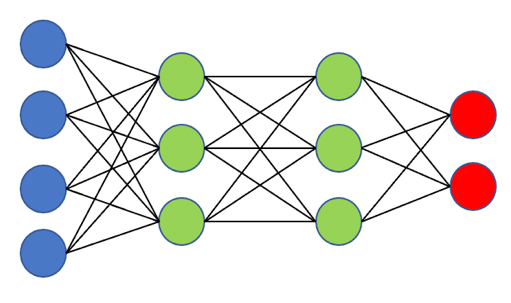 

- Blue = Input layer
- Green = Hidden layers
- Red = Output layer

- Input values for a scoring function relate to features that contribute to binding affinity
- These include tallies of protein-ligand atom contacts within specfic distance constraints, electrostatic contacts, hydrophobic contacts, ligand flexibility etc.
- Generation of descriptors that can be used to define binding affinity is an important step in the development of an ML-based SF
- Removal of descriptors that don't contribute to prediction accuracy is similarly important
- Removal of descriptors that contribute noise to the model is referred to as dimensionality reduction
- The optimum number of hidden layers and nodes in each layer for model performance is difficult to predict
- An iterative trial and error process to determine these seems like the best option
- Ensemble approaches to ANN seem to perform better - once the optimum architecture is determined training multiple ANNs on the same data
- These will end up with different weights based on how they were intiallised
- Then taking an average of the top performing networks as the output value
- Previous studies have used an average --> possible to take the top performing outputs and run them through an additional single hidden layer network --> will weight the more accurate models more favourably and may be more accurate than simply taking an average.

---

<a id='system_information'></a>
# __System Information__

__Local:__

In [ ]:
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.5 LTS"

__Remote Server:__<br>


In [ ]:
NAME="Scientific Linux"
VERSION="7.9 (Nitrogen)"
ID="scientific"
ID_LIKE="rhel centos fedora"
VERSION_ID="7.9"
PRETTY_NAME="Scientific Linux 7.9 (Nitrogen)"
ANSI_COLOR="0;31"
CPE_NAME="cpe:/o:scientificlinux:scientificlinux:7.9:GA"
HOME_URL="http://www.scientificlinux.org//"
BUG_REPORT_URL="mailto:scientific-linux-devel@listserv.fnal.gov"

REDHAT_BUGZILLA_PRODUCT="Scientific Linux 7"
REDHAT_BUGZILLA_PRODUCT_VERSION=7.9
REDHAT_SUPPORT_PRODUCT="Scientific Linux"
REDHAT_SUPPORT_PRODUCT_VERSION="7.9"
Scientific Linux release 7.9 (Nitrogen)
Scientific Linux release 7.9 (Nitrogen)
Scientific Linux release 7.9 (Nitrogen)

---

<a id='software'></a>
# __Software__

#### __MGLTools:__
- [Version 1.5.6](http://mgltools.scripps.edu/downloads)
- [Installation instructions](http://mgltools.scripps.edu/downloads/instructions/linux/)
- Command line:
    - cd path to installer
    - chmod a+x mgltools_Linux-x86_64_1.5.6_install
    - sudo ./mgltools_Linux-x86_64_1.5.6_install
    <br><br>
- [Version 1.5.7](https://ccsb.scripps.edu/mgltools/downloads/) gives errors when running pdbqt converter:
    - When running pdbqt conversion using ./pythonsh shell script for setting the python environment a numpy error occurs - multiple installations of python2.7 may be the cause
    - When running pdbqt conversion without ./pythonsh - MolKit module isn't found


#### __GWOVINA:__
- [Version 1.0](https://sourceforge.net/projects/gwovina/)
- Requires [Boost](https://www.boost.org/users/history/version_1_75_0.html)
- [Installation instructions](https://cbbio.online/software/gwovina/index.html)
- Installs as a binary executable - run through command line:
    - cd path to location where GWOVina is installed
    - /.gwovina

#### __BINANA:__

- [Version 1.3](https://git.durrantlab.pitt.edu/jdurrant/binana)
- Takes pdbqt files as inputs
- pdb files can be converted to pdbqt using GWOVina
- Is a python script - executable in the command line
- Use instructions in the documentation on github

#### __Openbabel:__

- [Version 3.2](https://github.com/openbabel/openbabel)
- Required for use of ODDT python library
- Requires a C++ compiler and [CMake](https://cmake.org) for installation
- Requires libopenbabel-dev, libopenbabel4v5, openbabel-gui and swig
- Installed on linux using the following command:

In [ ]:
# Unix code
sudo apt-get install libopenbabel-dev libopenbabel4v5 openbabel-gui swig

- [Installation instructions]()
- cmake terminal command options used:

In [ ]:
# Unix code
cmake -DPYTHON_BINDINGS=ON -DRUN_SWIG=ON -DPYTHON_EXECUTABLE=/usr/bin/python3 ../openbabel

#### __Python 3.6.9:__
- Using most recent version of python 3.6 as it's keras and tensorflow compatible 
- Libraries installed using command line "pip3 install _insert libary name_"
- Modules on my default python installation on my local machine:


#### __PyMOL:__
- [Version 2.4](https://pymol.org/2/)
- Requires a licence file to run
- Downloaded and extracted tar.bz2 file
- Run from command line:

In [ ]:
# Unix code
cd path/to/pymol/;
./pymol

#### __Anaconda 3:__
__Anaconda was installed on a remote server via ssh:__
- Dependencies:

In [ ]:
# Unix code
sudo yum install libXcomposite libXcursor libXi libXtst libXrandr alsa-lib mesa-libEGL libXdamage mesa-libGL libXScrnSaver

- Installation:

In [ ]:
# Unix code
wget https://repo.anaconda.com/archive/Anaconda3-2020.11-Linux-x86_64.sh
sha256sum Anaconda3-2020.11-Linux-x86_64.sh

>>> cf2ff493f11eaad5d09ce2b4feaa5ea90db5174303d5b3fe030e16d29aeef7de  Anaconda3-2020.11-Linux-x86_64.sh
bash Anaconda3-2020.11-Linux-x86_64.sh

# When asked:
Please answer 'yes' or 'no':
# Answer yes
>>> yes

# Input desired directory location
- Or specify a different location below
[/root/anaconda3] >>> /home/s1738716/anaconda3

# When asked:
Do you wish the installer to initialize Anaconda3
by running conda init? [yes|no]
# Answer yes
[no] >>> yes

- Opening bashrc for adding Anaconda to path:

In [ ]:
# Unix code
nano .bashrc

- Adding this line to the bashrc file before closing and reopening the ssh session:

In [ ]:
export PATH="/home/s1738716/anaconda3/bin:$PATH"

- To resource the .bashrc file close and reopen the ssh session

__Installing Anaconda on my local machine:__
- Download the [bash script installer](https://www.anaconda.com/products/individual)
- Run the bash script:

In [ ]:
# Unix code
$ bash /home/sammk/Research_Project/Software/Anaconda3-2020.11-Linux-x86_64.sh

Output:

In [ ]:
# Unix code
020.11-Linux-x86_64.sh

Welcome to Anaconda3 2020.11

In order to continue the installation process, please review the license
agreement.
Please, press ENTER to continue
# Press ENTER repeatedly until the end of the license agreement is reached
>>> (ENTER)

The licence agreement prints out - need to press enter to scroll through it. At the end of it:

In [ ]:
# Unix code
# When asked:
Do you accept the license terms? [yes|no]
# Answer yes
[no] >>> yes

Anaconda3 will now be installed into this location:
/home/sammk/anaconda3

  - Press ENTER to confirm the location
  - Press CTRL-C to abort the installation
  - Or specify a different location below

# Input desired directory location
[/home/sammk/anaconda3] >>> /home/sammk/Research_Project/Software/anaconda3

If you want the default python path to stay as the default and make python only run through anaconda when an environment is active:

In [ ]:
# Unix code
sudo nano ~/.bashrc

Comment out these lines:

In [ ]:
# >>> conda initialize >>>
# !! Contents within this block are managed by 'conda init' !!

__conda_setup="$('/home/sammk/Research_Project/Software/anaconda3/bin/conda' 'shell.bash' 'hook' 2> /dev/null)"
if [ $? -eq 0 ]; then
    eval "$__conda_setup"
else
    if [ -f "/home/sammk/Research_Project/Software/anaconda3/etc/profile.d/conda.sh" ]; then
        . "/home/sammk/Research_Project/Software/anaconda3/etc/profile.d/conda.sh"
    else export PATH="/home/sammk/Research_Project/Software/anaconda3/bin:$PATH"
    fi
fi
unset __conda_setup
# <<< conda initialize <<<

Add this line to the end of the ~/.bashrc for running conda:

In [ ]:
. /home/sammk/Research_Project/Software/anaconda3/etc/profile.d/conda.sh

Exit ~/.bashrc and resource ~/.bashrc:

In [ ]:
# Unix code
source ~/.bashrc

<a id='deepcoy'></a>
#### __DeepCoy:__
- [Paper](https://academic.oup.com/bioinformatics/advance-article/doi/10.1093/bioinformatics/btab080/6126797), [github](https://github.com/fimrie/DeepCoy), [pre-trained models](http://opig.stats.ox.ac.uk/resources)
- DOI: 10.1093/bioinformatics/btab080
- Pretrained deep learning model for generating property matched decoys of input actives
- Reduced levels of false negatives compared to DUD-E and DEKOIS
- Decoys were also less distinguishable from actives when using Autodock Vina
- May remove the bias that DUD-E introduces

DeepCoy was installed on the remote server via command line ssh on Miles McGibbon's server login (s1738716 instead of s1633589 in the path location):

In [ ]:
# Unix code
mkdir decoyGeneration
cd decoyGeneration
git clone https://github.com/fimrie/DeepCoy.git

A conda environment was built using the .yml file that comes with DeepCoy:

In [ ]:
# Unix code
cd DeepCoy
conda env create -f DeepCoy-env.yml

- __RdKit__ comes with this conda environment, so the problems mentioned below with RdKit installation should not be an issue with the DeepCoy conda environment.

To activate the conda environment

In [ ]:
# Unix code
conda activate DeepCoy-env

#### __RdKit:__<br>
RdKit __would not__ install on my installation of Ubuntu 18.04 using the instructions in the documentation - cmake produced an error on every attepted 'sudo make -jX' run despite varying the preceeding steps.

RdKit was installed instead within a conda environment on my machine:

The environment must activated and be running python3.6 or earlier, doesn't install with 3.7 or 3.8.

In [ ]:
# Unix code
conda install -c conda-forge rdkit

Miles installed RdKit on his machine using the installation instructions below:

This installation is **very complex, and took a huge amount of trial and error**. What ended up working was a tweaked version of the [guide published by OxPIG](https://www.blopig.com/blog/2013/02/how-to-install-rdkit-on-ubuntu-12-04/). This is exactly how I installed it on my machine:

First, install all the dependencies:

In [ ]:
# Unix code
sudo apt-get install flex bison build-essential python-numpy cmake python-dev sqlite3 libsqlite3-dev libboost-dev  libboost-python-dev libboost-regex-dev libfreetype6-dev

Then, cd into /opt (it seemed to be important that this was the folder it was installed in - the installation didn't work in other folders) and clone the current rdkit into this directory:

In [ ]:
# Unix code
cd /opt
sudo git clone https://github.com/rdkit/rdkit.git

Then, we need to define all the environmental variables for the install in our ~/.bashrc file:

In [ ]:
# Unix code
sudo nano ~/.bashrc

And add these lines to the bottom of the file:

In [ ]:
export RDBASE=/opt/rdkit
export LD_LIBRARY_PATH=$RDBASE/lib:$LD_LIBRARY_PATH
export PYTHONPATH=$RDBASE:$PYTHONPATH

Then save it and close it, and resource your bash file using:

In [ ]:
# Unix code
. ~/.bashrc

Then cd into the below directory in the $RDBASE file we defined in the bashrc file and run the specified bash script:

In [ ]:
# Unix code
cd $RDBASE/External/INCHI-API/
sudo ./download-inchi.sh

Then close the terminal, open a new terminal and cd into the $RDBASE again, then make a build folder and cd into that:

In [ ]:
# Unix code
cd $RDBASE
sudo mkdir build && cd build

Then run cmake:

In [ ]:
# Unix code
sudo cmake -DRDK_BUILD_INCHI_SUPPORT=ON -DPYTHON_EXECUTABLE=/usr/bin/python3 ..

And finally make (where X is the number of threads your machine can run - this takes a while) and then make install:

In [ ]:
# Unix code
sudo make -jX
sudo make install

---

<a id='databases'></a>
# __Databases__

The three databases used as a source for active structures to construct the training and testing sets are BindingMoad, PDBbind and Iridium. While there will be some redundancy between the three, the selection process is slightly different between them so there will be unique structures in each database.

#### __BindingMOAD:__
- Using [non-redundant & only with binding data](https://www.bindingmoad.org/Home/download)
- Database of binding affinities and associated PDB protein ligand structures
- Binding affinities in a csv format
- Csv file indicates the 'valid' ligand in the structure files and ligands that are part of the native protein
- Structures in biounit format - some of these were split into multiple files.
- Proteins and ligands need to be split and converted to pdbqt format for BINANA processing - BINANA takes proteins and ligands as separate input files
- Some biounit files include multiple copies of the protein ligand complex
- Biopython library can be used to process biounit files and generate new pdb files from chains/residues in the biounit files
- BindingMOAD was downloaded to the file path _/home/sammk/Research_Project/Data/Raw/MOAD/BindingMOAD_2020_ <br><br>
- In order to make BindingMOAD consistent with PDBbind the __original PDB structures__ were downloaded using the pdb codes in the BindingMOAD file names
- 3,187 structures in the raw dataset


In [14]:
#Script for scraping MOAD PDB files written by Miles

import os
import requests
from tqdm import tqdm

def create_target_url(filepath):
    
    # get the pdb code from the filename
    target_name = filepath.split('.')[0]
    
    # set the url string using the pdb code as where to download the pdb file
    target_url = f'https://files.rcsb.org/download/{target_name}.pdb'
    return target_url, target_name

def save_target_file(url):
    
    # get the file url and the target name
    url, target_name = create_target_url(url)
    
    # change this as to where you need to save the pdb files
    target_path = f'/home/sammk/Research_Project/Data/Raw/MOAD/original_PDB_files/{target_name}.pdb'
    response = requests.get(url)
    
    # ping the pdb and download the file if the url exists
    if response.status_code == 200:
        with open(target_path, 'wb') as file:
            file.write(response.content)
            file.close()
    else:
        print(f'Whoops! Somethings wrong: Response {response.status_code}')


# get the list of all the Binding_MOAD extracted protein-ligand complex pdb codes with no duplicates
filepaths = list(set(list([file.split('.')[0] for file in os.listdir('/home/sammk/Research_Project/Data/Raw/MOAD/BindingMOAD_2020')])))

# download the pdb files for all the Binding_MOAD extracted protein-ligand complex biounit files
'''
with tqdm(total=len(filepaths)) as pbar:
    for target_file in filepaths:
        save_target_file(target_file)
        pbar.update(1)
'''

'\nwith tqdm(total=len(filepaths)) as pbar:\n    for target_file in filepaths:\n        save_target_file(target_file)\n        pbar.update(1)\n'

Issues with MOAD:
- Includes protein structures as oligomers --> need to convert all proteins to monomers with a single binding site for the model to recognise
- Includes protein strucutures with binding sites that contain multiple ligands --> these need to be identified and removed
- Oligomer subunits are difficult to differentiate due to the heirarchical nature of pbd files --> different subunits often fall under the same id at the structure/chain level or if they do have different ids this is often not distinguishable from differing domain structures
- In cases where multiple binding sites are present for a ligand in oligomeric proteins with multiple copies of the same subunit the multiple copies of the same ligand all fall under the same residue ID - may have to use atom vector position or distance from a designated binding site to remove multiple copies of a ligand
- For example, 1a0t contains three homologous subunits with each possessing a binding site.

#### __PDBbind:__
- http://pdbbind.org.cn/download.php
- Latest version available is v.2019
- Using the 'refined set' of 4854 protein ligand complexes
- Inclusion is more stringent than the 'general set'
- Inclusion is based on crystal structure quality, binding data quality and the biological nature of the complex
- Data is therefore higher quality than the general set
- Ligands are in mol2 and sdf formats
- The protein pocket and the whole protein are included as pdb files
- Binding data is included in a text file
- PDBbind is the most 'BINANA ready' dataset out of the box.

#### __Iridium:__
- [Entire dataset](https://www.eyesopen.com/database-iridium)
- Within the download file are folders for the 'Not Trustworthy' (NT), 'Moderately Trustworthy' (MT) and 'Highly Trustworthy' (HT) datasets
- Smaller dataset, supposedly more stringent inclusion than BindingMOAD and PDBbind.
- Used the HT dataset which contains 120 structures
- The HT dataset excludes that are ligands covalently bound to target proteins
- Contains separate pdb files of proteins and sdf files of ligands
- Binding data in a xls spreadsheet

#### __LIT-PCBA:__
- http://drugdesign.unistra.fr/LIT-PCBA/
- Database of experimentally determined decoys
- Built with both virtual screening __and__ machine learning in mind.
- 15 target sets with 9,780 active and 407,839 unique inactives
- __There was limited overlap between our obtained actives and LIT-PCBA, so we decided to generated our own decoys using DeepCoy.__

#### __DUD-E:__
- __Bias in DUD-E dataset - no significant difference in performance between CNN image recognition based models trained on only the ligand and models trained on the ligand-receptor complex (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0220113). This suggests that DUD-E ligands may be misleading when training the model and affect overall performance. The model becomes trained to recognise the algorithm pattern used to generate decoys rather than patterns associated with binding interactions. As such, using decoys generated from DUD-E may be a misguided choice. Using decoys from other sources, such as DeepCoy and LIT-PCBA, seems like the best alternative.__<br><br>
- __May use DUD-E to generate decoys for PDBbind and MOAD crystal structures rather than use the library of actives and decoys that DUD-E provides. This would mean all the ligand bound crystal structures in the dataset would each have decoys, we'd be able to control the number of decoys per ligand and the accuracy of the pose of the docked ligand can be checked by reference to the protein-ligand crystal structure. The requirement for docking both actives and decoys in the DUD-E dataset would mean we would not have this reference for accuracy.__<br><br>
- http://dude.docking.org/
- Database of 22,886 active ligands against 102 target proteins and 50 decoys for each target
- Decoys are physico-chemically similar to actives but posses differing topology
- Downloaded as mol2 and SDF files
- Actives for each target in a multimol file
- Decoys for each target in a multimol file
- Need to be split
- Split using the biopandas library
- Seems like the ligands aren't predocked - when loaded into pymol ligands don't align with the receptor binding site
- May have to dock them ourselves with GWOVina (possibly have been predocked however this is unclear from the DUD-E wiki - see test.eel1.gz files) 


---

<a id='data_cleaning'></a>
# __Data Cleaning__

## __Work Flow Plan:__

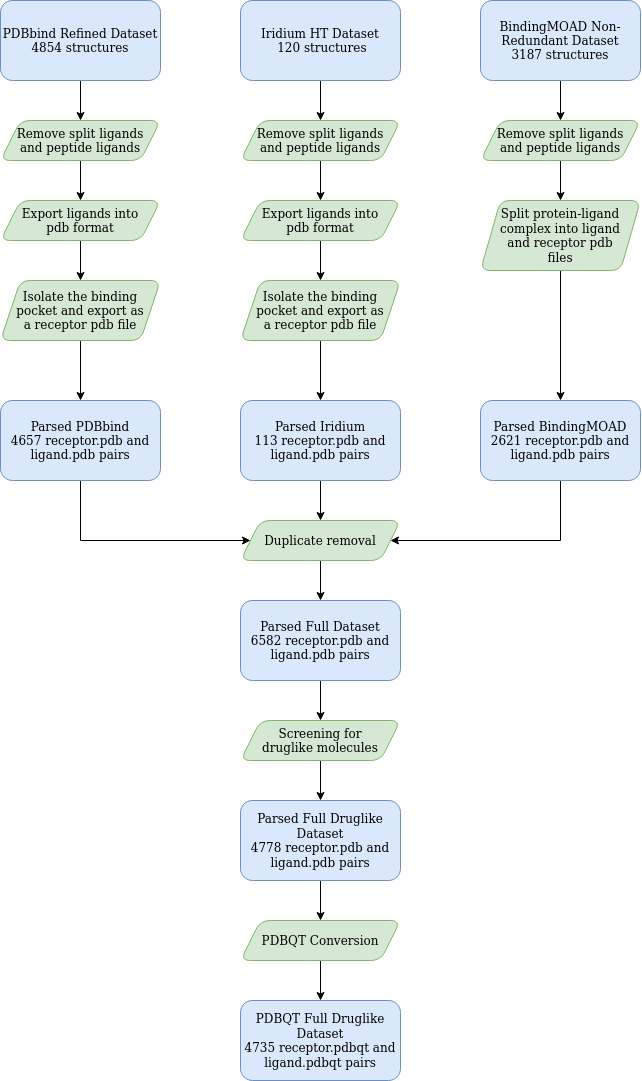

In [2]:
Image('Lab book Images/Structure data workflow.png')

The three datasets from PDBbind, BindingMOAD and Iridium need:
- To be filtered to remove structures with non-druglike ligands (>500 Da, >13 rotable bonds, peptides, split or broken ligands)
- All non-PDB files need to be converted to PDB format
- Scraped BindingMOAD protein-ligand structures need to be split into ligand and receptor binding pocket files
- PDBbind protein structures need to be used to generate receptor binding pocket files
- Redundant structures then need to be filtered out to produce a non-redundant dataset
- For running BINANA pdb files need to then be converted to pdbqt format by mgltools
- Duplicate structures need to be removed.

Resultant directory with full dataset for feature extraction will be 'Research_Project/Data/PDBQT/Successes/' containing:
- Folders named with pdb code containing:
  - active_ligand.pdbqt
  - receptor.pdbqt

## __BindingMOAD Cleaning:__

<a id='moad_issues'></a>
__It was noticed that the aromaticity of MOAD ligands was not presevered when converted to SMILES format. Aromaticity is only conserved if the files are converted like so: pdb --> mol2 --> pdb --> pdbqt --> SMILES. This is due to downloaded pdb files not explicitly including aromaticity - PyMOL infers aromaticity from HETATM arrangements. Using Openbabel to convert to mol2 and back to pbd adds explicit aromaticity. Because of this the decoys initially generated for MOAD structures were invalid. For now, MOAD has been removed from the dataset. They will added back in at a later date after the dissertation hand-in. The processing of including MOAD is still included in this lab book.__

The dataset full complex pdb files obtained from [the protein data bank](https://www.rcsb.org) using the pdb codes listed in the BindingMOAD dataset (scraped from https://www.rcsb.org/structure/insert_pdb_code_here). 
- Within the complex.pdb files are the active ligand, the target protein and other compounds listed in the accopanying 'nr_bind.csv' file. 
- These need to be separated into individual 'receptor.pdb' and 'ligand.pdb' files. 
- In the complex.pdb file, atoms belonging to amino acids are labelled as 'ATOM'. 
- All other atoms are labelled as 'HETATM' - including the active ligand(s), cofactors, waters, metal ions, sulphates and other non-active compounds used in the crystallisation process.


### __MOAD_protein_and_ligand_isolator.py__
Python script for:
- Splitting ligand and receptor into separate pdb files
- Removal of residues further than a specified distance from the active ligand
- Handling of oligomers
- Removal of structures with peptide ligands
- Removal of structures with broken ligands
- Removal of structures with multiple ligands in one binding site

Methodology:
- The csv file is loaded using the -ref input parameter
- For each complex:
- The active ligand ID is obtained from the csv file
- The ligand ID is used to save the only ligand atoms to a new pdb file, separate from the protein and other HETATMs (water etc.)
- All protein residues within a specific distance from the ligand are saved to a new pdb file called 'receptor.pdb' - in our case 14A was used as the cutoff point as this a commonly used distance in molecular dynamics simulations and local secondary structure is still included. This is an input parameter.
- Output is a directory with the pdb code as the name, containing ligand.pdb and receptor.pdb. This is an input parameter.
- Structures that the script determines are ones that shouldn't be kept are saved to a problem directory. This is an input parameter.
- To exclude structures with multiple ligands within one binding site, an exclusion argument is included
- All filtered out structures are copied to a 'problems' directory - these structures can be visually verified as not suitable if needed.

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 MOAD_pocket_and_ligand_isolator.py 
-loc /path/to/MOAD/structures/ 
-suc /path/to/output/directory/for/successes/ 
-prob /path/to/output/directory/for/problems/ 
-ref /path/to/nr_bind.csv 
-cutoff 'insert desired cutoff in angstroms' 
-exclusion 'insert desired exclusion in angstroms'

The input I used:

In [ ]:
# Unix code
# Input as one line
python3 MOAD_pocket_and_ligand_isolator.py 
-loc /home/sammk/Research_Project/Data/Raw/MOAD/original_PDB_files/ 
-suc /home/sammk/Research_Project/Data/Parsed/MOAD/Successes/ 
-prob /home/sammk/Research_Project/Data/Parsed/MOAD/Problems/ 
-ref /home/sammk/Research_Project/Data/Raw/MOAD/nr_bind.csv 
-cutoff 14 
-exclusion 5 

### __Structure Filtering within MOAD_protein_and_ligand_isolator.py:__

Within the BindingMOAD dataset there is variation how the ligand(s) are saved within their respective pdb complex files. Some of these aren't suitable for the training and testing sets and have been discarded, whereas others need to be kept. Structures we will cover below:
- Single ligand in one binding site
- Multiple ligands in one binding site
- Oligomeric structures and crystal lattice repeat units with many identical binding sites for one type of ligand
- Peptide ligands
- Multiple ligands in different binding sites classified with the same chain identifier

#### __Single Ligand in One Binding Site:__

We want these structures in our dataset - they are ideal for describing a single binding interaction between a receptor and a ligand and are perfect for BINANA feature extraction. Example structure 2p4t is shown from two angles below.

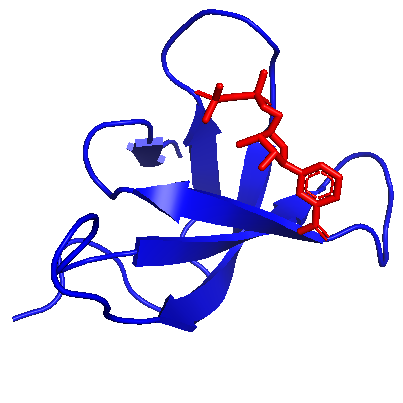 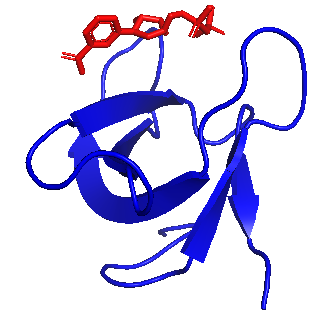 

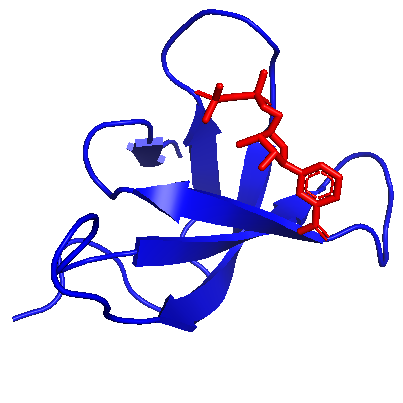

In [27]:
Image('Lab book Images/2p4t_a.png')

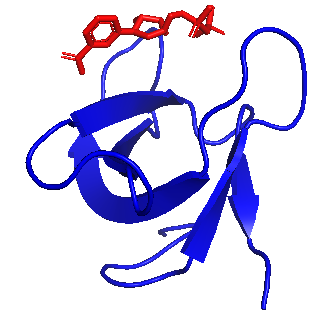

In [28]:
Image('Lab book Images/2p4t_b.png')

This structure possesses a single ligand, shown in red, bound to the protein target, shown in blue. After applying the 14A cutoff only two N-terminal residues were trimmed from this structure.

#### __Multiple Different Ligands in One Binding Site:__

There cases where multiple ligands are contained within a single binding site. 

For example, 6os6 is shown below with two active, __valid__ ligands located in the same binding site. Ligands shown in green and red, protein is shown in blue.

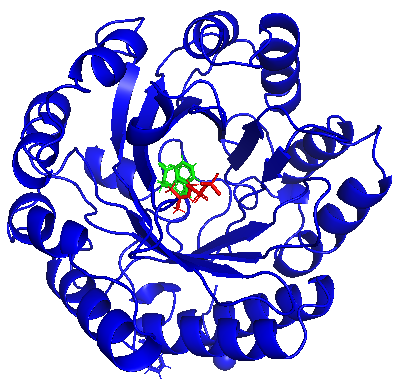

In [29]:
Image('Lab book Images/6os6_a.png')

We __do not__ want to keep these structures as binana can only take one ligand as an input - would add further complications to feature extraction and model building. Cooperative binding, and different stoichiometries would confuse the model as we're aiming to predict the Kd strength of 1:1 binding interactions. To filter these out, pdb files with HETATMS classed as being part of a different chain to the valid ligand, that are not 'part of the protein and reside __within 5 Angstoms__ of the valid ligand are not included. This is distance is determined by the exclusion input argument.

#### __Oligomeric Structures and Crystal Lattice Repeat Units With Many Binding Sites For One Ligand:__

There is a common occurence of oligomeric structures with repeating subunits which each contain a binding site and a bound copy of the valid ligand (this is also the case for crystal structures where the repeat unit in the crystal lattice contains multiple copies of the protein). These structures still have 1:1 binding and we want to keep them in the form of one copy of th eactive ligand within in one binding site. 

For example, 1e2k is shown below.

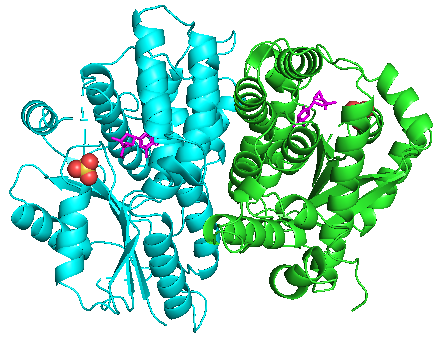

In [31]:
Image('Lab book Images/1e2k.png')

Two copies of the protein can be seen, one in cyan and the other in green. Within these are two identical binding sites, each containing a copy of the valid ligand (purple). We only need one copy of the binding site in these cases. The script picks valid ligand listed in the PDB file and defines the pocket around the dimensions of that ligand in line with the cutoff input, ignoring the identical other active ligands listed in the PDB file.

#### __Peptide ligands:__

The focus of this project is _small druglike molecules_. Peptide ligands don't fall into this category and may be misleading to the model. We have therefore filtered out __any valid ligand containing an amino acid__. Example structure 2vpe is shown from two angles below.

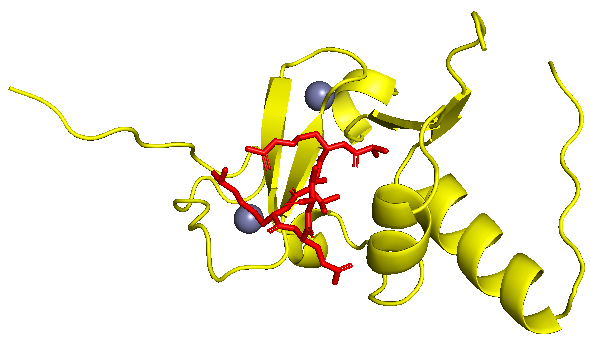

In [32]:
Image('Lab book Images/2vpe_a.png')

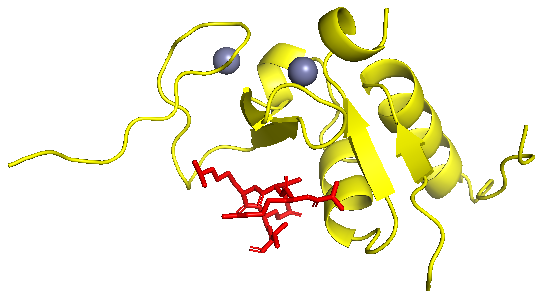

In [33]:
Image('Lab book Images/2vpe_b.png')

The active ligand (red) is constructed only from amino acids. This structure would not be kept by the script.

#### __Multiple ligands with the same chain identifier:__

A few structures in BindingMOAD contain multiple ligands not bound to each other, residing in different binding sites and both classified as being part of the same chain. For example, 1n1g possesses 3 BCP molecules bound in __two different binding sites__:

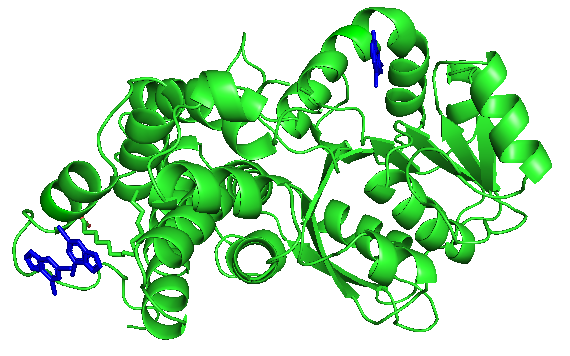

In [34]:
Image('Lab book Images/1n1g.png')

The 3 BCP molecules (blue) are clearly bound in different places. Despite this, __only one IC50 value__ accompanies this structure. As our model will require inputs of a single binding interaction and it's unclear what the IC50 value is for these binding site individually, __we will not keep these structures__.

However this a complication in identifying these structures computationally, as the 3 BCP molecules (residues 401, 402 and 403) are stored as a single chain (chain A) in the PDB file:

In [ ]:
HETATM 2605 CL   BCP A 401      31.650  54.989 -15.165  1.00 85.82          CL  
HETATM 2606  C6  BCP A 401      30.124  55.722 -14.616  1.00 85.37           C  
HETATM 2607  N1  BCP A 401      29.290  54.905 -13.998  1.00 87.25           N  
HETATM 2608  C2  BCP A 401      28.106  55.308 -13.524  1.00 88.68           C  
HETATM 2609 BR   BCP A 401      27.153  53.921 -12.700  1.00 96.07          BR  
HETATM 2610  C5  BCP A 401      29.678  57.132 -14.765  1.00 84.71           C  
HETATM 2611  C4  BCP A 401      28.374  57.494 -14.224  1.00 85.24           C  
HETATM 2612  N3  BCP A 401      27.617  56.571 -13.615  1.00 87.04           N  
HETATM 2613  N7  BCP A 401      30.204  58.230 -15.308  1.00 84.18           N  
HETATM 2614  C8  BCP A 401      29.293  59.236 -15.127  1.00 83.83           C  
HETATM 2615  N9  BCP A 401      28.180  58.797 -14.468  1.00 84.49           N  
HETATM 2616 CL   BCP A 402      32.640  55.944 -12.373  1.00 63.68          CL  
HETATM 2617  C6  BCP A 402      31.113  56.087 -11.461  1.00 66.16           C  
HETATM 2618  N1  BCP A 402      30.560  57.294 -11.320  1.00 69.28           N  
HETATM 2619  C2  BCP A 402      29.407  57.505 -10.643  1.00 71.75           C  
HETATM 2620 BR   BCP A 402      28.803  59.297 -10.547  1.00 82.45          BR  
HETATM 2621  C5  BCP A 402      30.385  54.961 -10.827  1.00 65.79           C  
HETATM 2622  C4  BCP A 402      29.152  55.263 -10.116  1.00 66.47           C  
HETATM 2623  N3  BCP A 402      28.700  56.516 -10.044  1.00 69.12           N  
HETATM 2624  N7  BCP A 402      30.598  53.648 -10.742  1.00 64.78           N  
HETATM 2625  C8  BCP A 402      29.556  53.144 -10.019  1.00 65.11           C  
HETATM 2626  N9  BCP A 402      28.672  54.117  -9.635  1.00 65.77           N  
HETATM 2627 CL  ABCP A 403      33.056  56.278  31.853  0.50 66.02          CL  
HETATM 2628 CL  BBCP A 403      34.775  51.536  27.783  0.50 66.68          CL  
HETATM 2629  C6 ABCP A 403      33.949  55.003  30.960  0.50 66.80           C  
HETATM 2630  C6 BBCP A 403      34.781  52.803  29.056  0.50 67.31           C  
HETATM 2631  N1 ABCP A 403      35.273  54.872  31.115  0.50 67.84           N  
HETATM 2632  N1 BBCP A 403      35.922  53.151  29.669  0.50 68.47           N  
HETATM 2633  C2 ABCP A 403      35.995  53.929  30.465  0.50 69.51           C  
HETATM 2634  C2 BBCP A 403      35.974  54.103  30.633  0.50 69.87           C  
HETATM 2635 BR  ABCP A 403      37.846  53.892  30.802  0.50 76.56          BR  
HETATM 2636 BR  BBCP A 403      37.657  54.471  31.395  0.50 76.94          BR  
HETATM 2637  C5 ABCP A 403      33.318  54.038  30.020  0.50 66.82           C  
HETATM 2638  C5 BBCP A 403      33.568  53.536  29.503  0.50 67.25           C  
HETATM 2639  C4 ABCP A 403      34.169  53.052  29.364  0.50 67.04           C  
HETATM 2640  C4 BBCP A 403      33.712  54.545  30.545  0.50 67.37           C  
HETATM 2641  N3 ABCP A 403      35.483  53.023  29.601  0.50 68.25           N  
HETATM 2642  N3 BBCP A 403      34.906  54.802  31.083  0.50 68.40           N  
HETATM 2643  N7 ABCP A 403      32.063  53.836  29.604  0.50 66.80           N  
HETATM 2644  N7 BBCP A 403      32.277  53.487  29.154  0.50 67.24           N  
HETATM 2645  C8 ABCP A 403      32.118  52.781  28.728  0.50 66.33           C  
HETATM 2646  C8 BBCP A 403      31.638  54.417  29.934  0.50 66.69           C  
HETATM 2647  N9 ABCP A 403      33.392  52.301  28.579  0.50 66.64           N  
HETATM 2648  N9 BBCP A 403      32.502  55.061  30.779  0.50 67.14           N  

To deal with this the script treats them as 'broken ligands'. If a ligand possesses more than one residue, ODDT and OpenBabel are used to identify if there are any __shared bonds__ between consecutive residues (e.g. between residue 401 and 402) that are assigned to a ligand. If no bond is found, as is this case with this structure, then it is discarded.

## __PDBbind Data Cleaning:__

The PDBbind dataset is already separated into protein and ligand files. The proteins are in pdb format and the ligands are in sdf and mol2 format. A receptor pdb file containing just the binding pocket is included, however we want the binding pocket files to have the same distance parameters from the ligand across all three datasets - the included pocket.pdb files have ~6A cutoff. Therefore, the 14 A cutoff that was applied to BindingMOAD will also be applied to PDBbind, following the same methodology, to produce a receptor.pdb file. Peptide protein-ligand pairs are included in the dataset and need to be removed as they don't fall into the under the druglike parameters that we are applying.

### __PDB_pocket_isolator.py__

Python script for:
- Conversion of ligand file to pdb format
- Removal of waters
- Removing structures with peptide ligands
- Removing structures with broken ligands
- Saving protein residues within 14 A of the ligand to a receptor.pdb file

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 PDB_pocket_isolator.py 
-loc /path/to/PDBbind/structures/ 
-suc /path/to/output/directory/for/successes/ 
-prob /path/to/output/directory/for/problems/ 
-cutoff 'insert desired cutoff in angstroms'

The inputs I used:

In [ ]:
# Unix code
# Input as one line
python3 PDB_pocket_isolator.py 
-loc /home/sammk/Research_Project/Data/Raw/PDBbind/refined-set/ 
-suc /home/sammk/Research_Project/Data/Parsed/PDBbind/Successes/ 
-prob /home/sammk/Research_Project/Data/Parsed/PDBbind/Problems/ 
-cutoff 14

Example 1bhx shown below. The first image is the full protein structures and the bound ligand both opened in PyMOL:

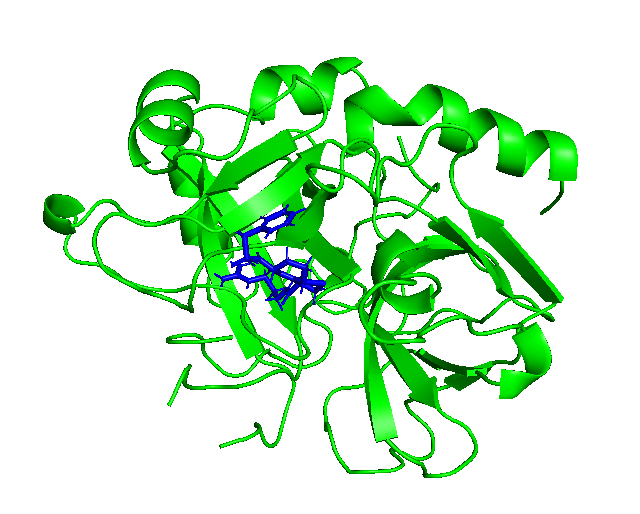

In [35]:
Image('Lab book Images/1bhx_full_prot.png')

The next image is of the included pocket.pdb file and the ligand file both opened in PyMOL:

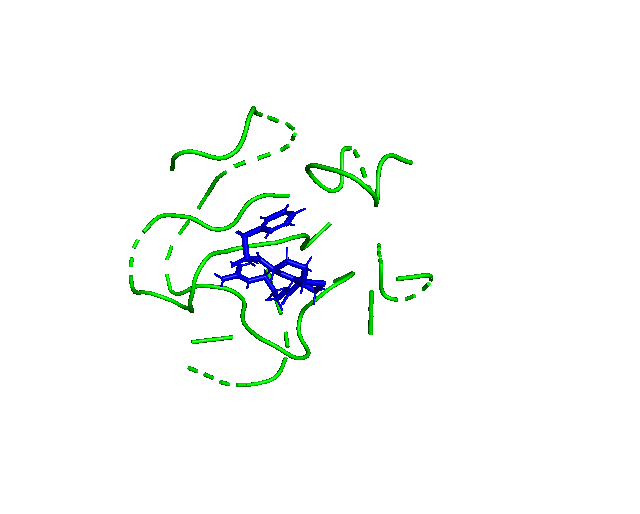

In [36]:
Image('Lab book Images/1bhx_pocket.png')

To ensure the size of a our receptor file is the same across all 3 databases the 14 A cutoff is applied instead of using the included pocket file: 

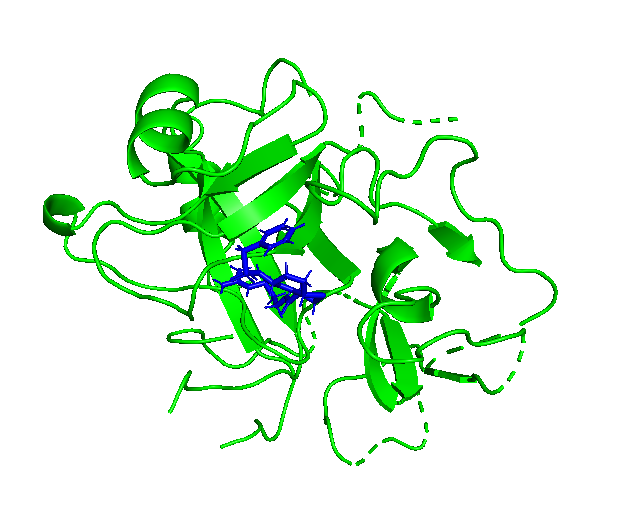

In [37]:
Image('Lab book Images/1bhx_receptor.png')

## __Iridium Data Cleaning:__

The Iridium HT dataset provides separate protein and ligand files. The protein binding pocket for each structure in the HT needs to be isolated in the same way as the other two databases. All protein residues within 14A of the ligand are need to saved to a new receptor.pdb file. Any peptide ligand and broken ligand pairs also need to be filtered out.

### __Iridium_pocket_isolator.py__

Python script for:
- Removal of waters
- Removing structures with peptide ligands
- Removing structures with broken ligands
- Saving protein residues within 14A of the ligand to a receptor.pdb file

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 Iridium_pocket_isolator.py 
-loc /path/to/Iridium/structures/ 
-suc /path/to/output/directory/for/successes/ 
-prob /path/to/output/directory/for/problems/ 
-cutoff 'insert desired cutoff in angstroms'

The inputs I used:

In [ ]:
# Unix code
# Input as one line
python3 Iridium_pocket_isolator.py 
-loc /home/sammk/Research_Project/Data/Raw/Iridium/Iridium/iridium-HT/deposited/ 
-suc /home/sammk/Research_Project/Data/Parsed/Iridium/Successes/ 
-prob /home/sammk/Research_Project/Data/Parsed/Iridium/Problems/ 
-cutoff 14

## __Duplicate Removal:__

As Iridium HT is claimed to be the most stringent of the three databases and PDBbind comes in a more appropriate 'ready' format for feature extraction, duplicates will be kept according to the following preference order:
1. Iridium HT
2. PDBbind Refined Set
3. BindingMOAD Non-Redundant

The script below was used to filter out duplicate structures.

In [12]:
import os
import shutil
from tqdm import tqdm

def duplicate_remove():

    pdbbind_structures = os.listdir('/home/sammk/Research_Project/Data/Parsed/PDBbind/Successes')

    binding_MOAD_structures = os.listdir('/home/sammk/Research_Project/Data/Parsed/MOAD/Successes')

    iridium_structures = os.listdir('/home/sammk/Research_Project/Data/Parsed/Iridium/Successes')

    pdbbind_clean_structures = [structure for structure in pdbbind_structures]
    binding_MOAD_clean_structures = [structure for structure in binding_MOAD_structures]
    iridium_clean_structures = [structure for structure in iridium_structures]

    MOAD_exclusives = list()
    pdbbind_exclusives = list()

    for structure in pdbbind_clean_structures:
        if structure not in iridium_clean_structures:
            pdbbind_exclusives.append(structure)

    for structure in binding_MOAD_clean_structures:
        if structure not in iridium_clean_structures:
            if structure not in pdbbind_clean_structures:
                MOAD_exclusives.append(structure)

    print(f'{len(iridium_clean_structures)} structures from Iridium')
    print(f'{len(pdbbind_exclusives)} structures from PDBBind')
    print(f'{len(MOAD_exclusives)} structures from Binding MOAD')

    os.mkdir('/home/sammk/Research_Project/Data/Parsed/Non_redundant')
    os.mkdir('/home/sammk/Research_Project/Data/Parsed/Non_redundant/PDBbind')
    os.mkdir('/home/sammk/Research_Project/Data/Parsed/Non_redundant/MOAD')
    os.mkdir('/home/sammk/Research_Project/Data/Parsed/Non_redundant/Iridium')
    os.mkdir('/home/sammk/Research_Project/Data/Parsed/Non_redundant/Full')

    pdbbind_structures_filepaths = [f'/home/sammk/Research_Project/Data/Parsed/PDBbind/Successes/{file}' for file in pdbbind_structures]

    MOAD_exclusives_filenames = list()
    for pdb_code in MOAD_exclusives:
        for filename in binding_MOAD_structures:
            pdb_code_upper = pdb_code.upper()
            filename_upper = filename.upper()
            if pdb_code_upper in filename_upper:
                MOAD_exclusives_filenames.append(filename)

    iridium_structures_filepaths = [f'/home/sammk/Research_Project/Data/Parsed/Iridium/Successes/{file}' for file in iridium_clean_structures]
    pdbbind_exclusive_structures_filepaths = [f'/home/sammk/Research_Project/Data/Parsed/PDBbind/Successes/{file}' for file in pdbbind_exclusives]
    binding_MOAD_exclusive_structures_filepaths = [f'/home/sammk/Research_Project/Data/Parsed/MOAD/Successes/{file}' for file in MOAD_exclusives]

    with tqdm(total=len(iridium_structures_filepaths)) as pbar:
        for filepath in iridium_structures_filepaths:
            filename = filepath.split('/')[len(filepath.split('/')) - 1]
            shutil.copytree(filepath, f'/home/sammk/Research_Project/Data/Parsed/Non_redundant/Iridium/{filename}')
            shutil.copytree(filepath, f'/home/sammk/Research_Project/Data/Parsed/Non_redundant/Full/{filename}')
            pbar.update(1)

    with tqdm(total=len(pdbbind_exclusive_structures_filepaths)) as pbar:
        for filepath in pdbbind_exclusive_structures_filepaths:
            filename = filepath.split('/')[len(filepath.split('/')) - 1]
            shutil.copytree(filepath, f'/home/sammk/Research_Project/Data/Parsed/Non_redundant/PDBbind/{filename}')
            shutil.copytree(filepath, f'/home/sammk/Research_Project/Data/Parsed/Non_redundant/Full/{filename}')
            pbar.update(1)

    with tqdm(total=len(binding_MOAD_exclusive_structures_filepaths)) as pbar:
        for filepath in binding_MOAD_exclusive_structures_filepaths:
            filename = filepath.split('/')[len(filepath.split('/')) - 1]
            shutil.copytree(filepath, f'/home/sammk/Research_Project/Data/Parsed/Non_redundant/MOAD/{filename}')
            shutil.copytree(filepath, f'/home/sammk/Research_Project/Data/Parsed/Non_redundant/Full/{filename}')
            pbar.update(1)

#duplicate_remove()

113 structures from Iridium
4617 structures from PDBBind
1852 structures from Binding MOAD


100%|██████████| 1852/1852 [00:08<00:00, 215.33it/s]


The resultant non-redundant dataset was saved to:

In [ ]:
/home/sammk/Research_Project/Data/Parsed/Non_redundant/Full/

## __Filtering for Druglike Molecules:__

The focus of the model is binding interactions between __small druglike molecules and target proteins__. Therefore, any non-druglike ligands need to be filtered out as they may skew model predictions. The definition we will be using for 'druglike' ligands is **$\le$ 500 Da Mw and $\le$ 13 rotatable bonds**.

### __Issues with screening:__
When using Openbabel (via ODDT's wrapper) to screen for rotatable bonds, the result for the number of rotatable ligand bonds was different for pdb and pdbqt files for the same ligand. Additionally, these results were often __significantly different__ to the result output by BINANA. This meant that a number of actives with more than 13 rotatable bonds were inadvertently included in the initial dataset. Since we are now screening pdbqt files for rotatable bonds due to these issues, we must also screen for molecular weight at the same stage. As a number of the dataset pdb files were fully hydrogenated (not all of them) and the pdbqt files only have polar hydrogens, some more ligands will be within the molecular weight constraint. This also means all ligands are hydrogenated in the same way when screened for molecular weight.

### __druglike_screener.py__

Python script for:
- Removing protein-ligand pairs where ligands are over 500 Da in Mw
- Removing protein-ligand pairs where ligands are over 13 rotable bonds

Ligand pdb files from the input directory are iteratively opened and checked if it meets the filters. If it pass the folder containing the ligand, the protein and the receptor file is copied to the desiination directory. If the ligand fails to meet either one the folder isn't copied.

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 druglike_screener.py 
-loc /path/to/parsed/non/redundant/full/dataset 
-des /path/to/move/druglike/structures/to/ 
-mw "insert max molecular weight threshold" 
-rot "insert max rotatable bonds threshold"

The inputs I used:

In [ ]:
# Unix code
# Input as one line
python3 druglike_screener.py 
-loc /home/sammk/Research_Project/Data/Parsed/Non_redundant/Full/ 
-des /home/sammk/Research_Project/Data/Parsed/Non_redundant/Full_Druglike/ 
-mw 500 
-rot 13 

## __PDBQT Conversion:__

The ligand and receptor files in the non-redundant full druglike directory are in pdb format. Binana, the python script we will be using for feature extraction, takes ligand and receptor pdbqt files as inputs. The pdb files therefore have to be converted into pdbqt format. This can be done using two python scripts included with Autodocktools: prepare_ligand4.py and prepare_receptor4.py

Input parameters for protein and ligand pdbqt conversion:

In [ ]:
# Unix code
- prepare_ligand4.py -l ligand.pdb -A hydrogens -o ligand.pdbqt
- prepare_receptor4.py -r protein.pdb -A hydrogens -o protein.pdbqt -U waters

These parameters add polar hydrogens and gasteiger charges to the ligand and receptor and remove waters from the receptor.

### __multithread_pdbqt_batch_converter.py__

Python script for pdbqt conversion of all the receptor and ligand pdb files in the full non-redundant druglike directory. The pdbqt files are saved to a another directory, structures that can't be converted are copied to a problems directory and a list of the erroneus structures are saved to a text file, 'fatal_errors_list.txt'.

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 multithread_pdbqt_batch_converter.py 
-loc /path/to/pdb/structure/folders/ 
-suc path/to/output/directory/for/successes/ 
-prob path/to/output/directory/for/problems/ 
-prep_lig path/to/prepare_ligand4.py 
-prep_prot path/to/prepare_receptor4.py 
-threads "Insert the number of available CPU threads"

The inputs I used:

In [ ]:
# Unix code
# Input as one line
python3 multithread_pdbqt_batch_converter.py 
-loc /home/sammk/Research_Project/Data/Parsed/Non_redundant/Full_Druglike/ 
-suc /home/sammk/Research_Project/Data/PDBQT/Successes/ 
-prob /home/sammk/Research_Project/Data/PDBQT/Problems/ 
-prep_lig /home/sammk/Research_Project/Software/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24/prepare_ligand4.py 
-prep_prot /home/sammk/Research_Project/Software/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24/prepare_receptor4.py 
-threads 12

## __Binding Data Sorting:__

The binding data from each of three database sources came in the form of __IC50__, __Kd__ and __Ka__ values with a variety of different units (uM, nM, pM etc). These need to be extracted, combined and put in a uniform format for model training and testing. 

### __binding_data_sort.py__

Python script for:
- Opening the three data sheets for each dataset
- Reading the PDBQT folder names
- Combining all the binding data for every folder in the PDBQT directory into a csv file (__bindingData.csv__)
- Removing PDBQT structures without binding data
- Filtering out CC50 structures
- Converting all values to uM
- Filtering out IC50 values within a specified threshold
- Adding a 'Label' column for binary strength classification
- Saving converted data to another csv file  (__convertedBindingData.csv__)

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 binding_data_sort.py 
-irid /path/to/iridium/binding/data/Iridium_DOI_DPI_RES.xls 
-pdb /path/to/PDBbind/binding/data/INDEX_refined_data.2019 
-moad path/to/BindingMOAD/binding/data/nr_bind.csv 
-pdbqt /path/to/pdbqt/successes/directory/ 
-threshold "insert binary classification threshold in uM" 
-output_dir /path/to/directory/for/saving/csv/files/

Inputs I used:

In [ ]:
# Unix code
# Input as one line
python3 binding_data_sort.py 
-irid /home/sammk/Research_Project/Data/Raw/Iridium/Iridium/Iridium_DOI_DPI_RES.xls 
-pdb /home/sammk/Research_Project/Data/Raw/PDBbind/plain-text-index/index/INDEX_refined_data.2019 
-moad /home/sammk/Research_Project/Data/Raw/MOAD/nr_bind.csv 
-pdbqt /home/sammk/Research_Project/Data/PDBQT/Successes/ 
-threshold 25 
-output_dir /home/sammk/Research_Project/Data/

11 Iridium structures had no associated binding in the Iridium spreadsheet:<br>
    
    1g9v, 1sq5, 1pbd, 1gm8, 1u4d, 1rob, 1p62, 1ukz, 1r9o, 1unl, 4aah

These structures were removed from the dataset, leaving __4724__ active protein-ligand structures with binding data.

The binding data comes as __IC50__, __Kd__ and __Ka__ values. The IC50 and Kd values are in various units (M, mM, uM, nM and pM) - these are all converted to uM units. Ka values are all in $M^{-1}$ units - these are converted to uM Kd (Kd = 1/Ka).

One structure (1c1b) comes with a __CC50__ value - this strucuture was removed from the dataset.

The python script takes the desired threshold for the model as an input. This is used in the IC50 filtering and creating the 'Label' column for binary classification.

#### __IC50 Conversion Problem:__

From IC50, Kd for a binding interaction can be estimated using the __Cheng-Prusoff equation__:

$$
Kd = \frac{IC50}{1 + \frac{[L]}{Km}}
$$

However, for every IC50 value this conversion requires the concentration of ligand used in the assay and the Michaelis-Menten Constant for the binding interaction.

As we are performing __binary classification__ using a specifid threshold value, we do not nessesarily need to calculate exact Kd. For instance, the minimum value that IC50 will be divided by in the Cheng-Prusoff equation is __1__, therefore, all IC50 values below the threshold Kd will also have a Kd value below the threshold. IC50 values above the threshold __aren't guaranteed to have Kd values above the threshold__. As maximising the amount of data available for model training is a priority, it is a __necessity to included as many IC50 values as possible__. To reduce the number of false negatives of IC50 actives for binary classification, the binding_data_sort.py script __filters out__ IC50 binding values __between the threshold and 10 x the threshold__. All binding values above 10 times the threshold are assumed to have a Kd above the threshold. For our dataset this removes 29 structures:

    29 structure(s) do not meet IC50 value requirements:
    1b9v, 3ond, 1k3t, 2dm6, 2vtd, 6djj, 2j83, 4mob, 5hmr, 4lh7, 2vl8, 2pt9, 2bnf, 5jdc, 6gcl, 5k6a, 1yhm, 6n69, 4w9n, 2bve, 5tuf, 6phr, 3qsb, 5lx6, 5mrh, 4lqy, 4u31, 2boi, 3cv6

This leaves __4694__ active structures for decoy generation and feature engineering

#### __convertedBindingData.csv__

This output file contains all the binding data for active filtered structures with the following headers:
- __PDBCode__ - The pdb code of the protein-ligand pair
- __BindingDataType__ - The type of binding data that comes with the pair (Ki, Kd, Ka, IC50, CC50)
- __BindingValue__ - The numerical binding data value that comes with the pair
- __BindingUnits__ - The units of the numerical value
- __Database__ - The source database for the protein-ligand pair
- __Binding_Data_in_uM__ - The numerical value converte to uM
- __Label__ - Binary classification of the binding data as strong (Kd < threshold) and weak (Kd > threshold). 1 is strong, 0 is weak.

---

<a id='property_matched_decoy_generation'></a>
# __Property Matched Decoy Generation & Docking__

For [DUD-E](http://dude.docking.org/), it has been shown that "_high performance of CNN models trained on DUD-E is not attributable to having learned the features of protein-ligand interactions but rather to analogue and decoy bias inherent in the DUD-E dataset_"  and it has been warned that "_Due to the the hidden biases in the DUD-E dataset ... one should be very cautious when using DUD-E for machine learning based methodology development_" [(Chen, L. et al., 2019)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0220113).

[LIT-PCBA](http://drugdesign.unistra.fr/LIT-PCBA/) is a dataset of proteins with experimentally verified actives and inactives for each target. Upon querying LIT-PCBA, it was found that there was only 0.9% of the target proteins obtained from Iridium, PDBbind and BindingMOAD were represented in the LIT-PCBA dataset. This means that using LIT-PCBA as a source of inactives will create a model bias for classifying  protein targets from Iridium, PDBbind and BindingMOAD as actives rather than accurately identifying structural features that are indicative of strong binding. Therefore, LIT-PCBA __will not__ be used as a source for inactives.

## __Using DeepCoy to Generate Unbiased Inactives:__

[DeepCoy](https://academic.oup.com/bioinformatics/advance-article/doi/10.1093/bioinformatics/btab080/6126797?login=true) takes active ligand structures as in inputs in SMILES format. Active ligands are all in pdb and pdbqt format following the data cleaning stage. RDKit was used to convert the __pdb__ ligand files into SMILES format.

DeepCoy can only take ligands with specific atom types. As a result DeepCoy couldn't be used to generate decoys for __16__ active ligands. To prevent model bias for predicting ligands with these atom types as strong binders these structures were ditched.

For __260__ structures the decoys could not be docked - these included all the structures that produced a float error when run through BINANA. These were also ditched.

By default, DeepCoy doesn't take __phosphorus containing__ ligands. Ligands with and without phosphorus need to therefore be split amd run through different DeepCoy models. 

When running DeepCoy, 1000 decay molecules were generated for each active. The evaluation script that comes with DeepCoy was then used to select the 15 best decoys per active.

A number of structures only produced 14 or 13 satisfactory decoys which passed the evaluation.

This left a full dataset of __70,682__ ligands for __4418__ receptors.

### __make_pdb_copies.py__

Python script for copying pdb versions of ligands found in the PDBQT druglike folder to a new directory.

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 make_pdb_copies.py
-loc /path/to/directory/of/folders/with/pdb/structures/
-des /path/to/directory/to/copy/pdb/structures/to/
-ref /path/to/pdbqt/druglike/structures/

Inputs I used:

In [ ]:
# Unix code
# Input as one line
python3 make_pdb_copies.py
-loc /home/sammk/Research_Project/Data/Parsed/Non_redundant/Full_Druglike/
-des /home/sammk/Research_Project/Data/SMILES/pdb_copies/
-ref /home/sammk/Research_Project/Data/PDBQT/Successes/

### __smile_generator.py__

Python script for:
- Converting ligand pdb files to SMILES format
- Saving all active SMILES ligands to a text file(s) with one ligand per line. This text file(s) will be parsed to DeepCoy for decoy generation.
- Producing a csv file which can be used as a reference when sorting the DeepCoy output.
- A small number of pdb ligand files which were generated from mol2 ligand files from PDBbind using OpenBabel could not be converted into SMILES files by RDKit
- When this occurs, the script attempts to convert the original mol2 file to SMILES format.
- If this doesn't work either the ligand is ignored - this was the case with a small number of ligands
- The script has an option for converting only phosphororus containing ligands or converting only ligands without phosphorus - this can be used to split SMILES files by whether or not they contain phosphorus.
- The script has the option of equally splitting the SMILES output into multiple files - this enables running multiple instances of DeepCoy at once over each split, resulting in a shorter overall runtime

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 smile_generator.py
-loc /path/to/copied/directory/of/folders/with/pdb/structures/
-backup /path/to/mol2/backups/
-phos "True is for only phosphorus ligands, False is for only non-phosphorus ligands"
-split "Insert the number of files the output should be split into"

Inputs I used:

In [ ]:
# Unix code
# Input as one line
# For phosphorus ligands
python3 smile_generator.py
-loc /home/sammk/Research_Project/Data/SMILES/pdb_copies/
-backup /home/sammk/Research_Project/Data/Raw/PDBbind/refined-set/
-phos
-split 4

In [ ]:
# Unix code
# Input as one line
# For non-phosphorus ligands
python3 smile_generator.py
-loc /home/sammk/Research_Project/Data/SMILES/pdb_copies/
-backup /home/sammk/Research_Project/Data/Raw/PDBbind/refined-set/
-split 12

<a id='deepcoysetup'></a>
### __Running DeepCoy for Non-Phosphorus Containing Ligands:__

DeepCoy was run on the remote server. The conda environment included with DeepCoy was setup as [previously described](#deepcoy) on the remote server via ssh. Activating the DeepCoy conda environment:

In [ ]:
# Unix code
conda activate DeepCoy-env

Creating a folder for the DeepCoy output SMILES:

In [ ]:
# Unix code
cd DeepCoy
mkdir final_decoys

The 12 SMILES files, each containing 341 active non-phosphorus ligand structures, that were output from smile_generator.py were used with the default DeepCoy model. These were copied to the remote server (address redacted):

In [ ]:
# Unix code
scp /home/milesm/Dissertation/Code/decoyGenerationAndDocking/np_actives_0-341.txt XXXX@XXXX.XXX.XXX.XX:/home/s1738716/decoyGeneration/DeepCoy/data

__For each SMILES file:__

A screen was created for a specific molecule batch file:

In [ ]:
# Unix code
screen -S molecules_0-341

SMILES file was prepare for DeepCoy:

In [ ]:
# Unix code
conda activate DeepCoy-env && cd decoyGeneration/DeepCoy/data
python prepare_data.py --data_path np_actives_0-341.smi --dataset_name np_0-341

DeepCoy was executed, generating 1000 decoys per active:

In [ ]:
# Unix code
cd .. && python DeepCoy.py 
--restore models/DeepCoy_DUDE_model_e09.pickle 
--dataset zinc
--config '{"generation": true, 
            "number_of_generation_per_valid": 1000, 
            "batch_size": 1, 
            "train_file": "data/molecules_np_0-341.json", 
            "valid_file": "data/molecules_np_0-341.json", 
            "output_name": "output/DeepCoy_decoys_np_molecules_0-341.smi", 
            "use_subgraph_freqs": false}'

### __Running DeepCoy for Phosphorus Containing Ligands:__

For phosphorus containing ligands, prepare_data.py outputs:

In [ ]:
"Unknown atom type P5(0)"

Miles contacted Fergus Imrie (author of DeepCoy) to enquire about how he prepared data for the phosphorus DeepCoy model. He did not reply. The following is the approach we took based on the supplementary documentation provided with DeepCoy.

Open utils.py

In [ ]:
# Unix code
cd DeepCoy
nano utils.py

The following was added to the dictionary on line 36, dataset:
- To the list "atom_types", "P5(0)" was added (line 37)
- To the dict "maximum_valence", "15:5" was added (line 38)
- To the dict "number_to_atom", "14:'P'" was added (line 39)

In [ ]:
elif dataset=='zinc':
    return { 'atom_types': ['Br1(0)', 'C4(0)', 'Cl1(0)', 'F1(0)', 'H1(0)', 'I1(0)',
            'N2(-1)', 'N3(0)', 'N4(1)', 'O1(-1)', 'O2(0)', 'S2(0)','S4(0)', 'S6(0)','P5(0)'],
             'maximum_valence': {0: 1, 1: 4, 2: 1, 3: 1, 4: 1, 5:1, 6:2, 7:3, 8:4, 9:1, 10:2, 11:2, 12:4, 13:6, 14:3, 15:5},
             'number_to_atom': {0: 'Br', 1: 'C', 2: 'Cl', 3: 'F', 4: 'H', 5:'I', 6:'N', 7:'N', 8:'N', 9:'O', 10:'O', 11:'S', 12:'S', 13:'S',14:'P'},
             'bucket_sizes': np.array([28,31,33,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,55,58,84])
           }

The process of moving and preparing data before running DeepCoy was performed as [described previously](#deepcoysetup):

The 4 SMILES files were moved to the remote server:

In [ ]:
# Unix code
scp /home/milesm/Dissertation/Code/decoyGenerationAndDocking/p_actives_0-155.txt XXXX@XXXX.XXX.XXX.XX:/home/s1738716/decoyGeneration/DeepCoy/data

__For each SMILES file:__


A screen was created for a specific molecule batch file:

In [ ]:
# Unix code
screen -S p_molecules_0-155

SMILES file was prepare for DeepCoy:

In [ ]:
# Unix code
conda activate DeepCoy-env && cd decoyGeneration/DeepCoy/data
python prepare_data.py --data_path p_actives_0-155.smi --dataset_name p_0-155

DeepCoy was executed:

In [ ]:
# Unix code
cd .. && python DeepCoy.py 
--restore models/DeepCoy_DUDE_phosphorus_model_e10.pickle 
--dataset zinc 
--config '{"generation": true, 
            "number_of_generation_per_valid": 1000, 
            "batch_size": 1, 
            "train_file": "data/molecules_p_0-155.json", 
            "valid_file": "data/molecules_p_0-155.json", 
            "output_name": "output/DeepCoy_decoys_p_molecules_0-155.smi", 
            "use_subgraph_freqs": false}'

## __Screening & Evaluating Decoys:__

After batches were completed the decoys were screened for the number of rotatable bonds, as generated decoys could contain more rotatable bonds than the active, allowing decoys with more than 13 rotatable bonds to be present in the dataset. As rotatable bonds is a feature that we will parse to the model, decoys with more than 13 rotatable bonds will create significant model bias and need to be filtered out prior to evaluation.

### __druglike_screen_generated_decoys.py__

Python script for:
- Removing decoys with more than 13 rotatable bonds from the 1000 generated
- Outputs new SMILES file in the 'screen_output' directory  for evaluation

This script is written to be run within the DeepCoy folder on the remote server in the DeepCoy-env conda environment.

Terminal input parameters:

In [ ]:
# Unix code
python druglike_screen_generated_decoys.py -num_rots "Insert desired threshold for rotatable bonds"

Inputs used:

In [ ]:
# Unix code
python druglike_screen_generated_decoys.py -num_rots 13

### __Evalutation__

To select the best 15 decoys for each active the following procedure was carried out:

The 'screen_output' directory was copied

In [ ]:
# Unix code
mkdir working_output
cp ./screened_output/*.smi ./working_output

DeepCoy's evaluation script, __select_and_evaluate_decoys.py__, was run

In [ ]:
# Unix code
cd evaluation
python select_and_evaluate_decoys.py --data_path  /home/s1738716/decoyGeneration/DeepCoy/working_output/ --output_path /home/s1738716/decoyGeneration/DeepCoy/final_decoys/ --dataset_name dude_ext --num_decoys_per_active 15 --min_active_size 1 --num_cores 16 --min_num_candidates 10 >> decoy_selection_log.txt

The results.csv file was moved out of the 'final_decoys' directory

In [ ]:
# Unix code
cd -
mkdir metrics
mv ./final_decoys/results.csv ./metrics

The results file was copied off the remote server

In [ ]:
# Unix code
scp XXXXXX@XXXXXXX:/home/s1738716/decoyGeneration/DeepCoy/metrics/results.csv /home/milesm/Dissertation/Code/decoyGenerationAndDocking/decoyResults

The output SMILES file format is: {acitve}{decoy}\n with 15 decoys per active. For example:

In [ ]:
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 C=C1COCC=C1C(=O)NNC(=O)COC(=O)C1CSC(=S)S1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 COS(=O)(=O)C1=C2NC(=O)NCCC=CCC(=O)C=C2CS1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 O=CC=C(C=C1SCC(=O)NC1=S)S(=O)(=O)NC1=CCOC=C1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 Cc1cc2c(=O)[nH]c(=O)sc2c(=O)n1Cc1ccc([SH](=O)=O)s1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CCNS(=O)(=O)C1=CC(=O)C(SC)=CC1=C1SC(=O)N(C)C1=O
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CC=C1SC(SC2CCS(=O)(=O)C2)=C(C(=O)NC)C(=O)NC1=O
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CC(=O)C1=CNC(=CSC(=S)N[SH](=O)=O)C(C(=O)OC(C)C)=C1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CS(=O)(=O)C1CCC(NC(=O)NC2=CC=CSC2[SH](=O)=O)CC1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CSc1cc(S)ccc1OC(=O)Nc1cc([SH](=O)=O)c[nH]c1=O
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 COC(=O)C1=CC(=O)C=C(C)SC(=S)NC(=O)SC(C)C(=O)N1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 O=C1C=C(NC(=O)C(=O)NC(=O)Sc2cccs2)C(=CCO)S1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CC=C(S)C1=C(NC(=O)OCC(=O)OC)C(=CC(=S)S)C(=O)N1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CCOC(=O)N(C)C(=O)C(=O)NC(=CC(=O)SC)C1SC=CS1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CNc1cccc(OC(=O)NC(=S)SC2C(=O)OCCS2=O)c1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 COC(=O)Cn1c2c(c(=O)[nH]c1=S)C(C)C1=C(S2)S(=O)(=O)CC1

### __Verifying Decoy Evaluation__

For some actives, less than 15 decoys were selected by the evaluation script. Some had no decoys selected and had some ommitted from the final_decoy SMILES files. Actives with less than 15 decoys are always at the end of the SMILES file output (possible bug with the evaluation script cutting off early). The actives were re-evaluated and the initally selected decoys were manually deleted from the SMILES files in final_decoys directory.

### __verify_decoys.py__

Python script for:
- Counting the number of selected decoys for each active
- Copying all 1000 generated decoys for actives with fewer than 15 selected decoys to a new SMILES file called re_evaluate_decoys.smi
- This SMILES file was evaluated again

Terminal input (run in the DeepCoy directory, in the DeepCoy-env conda environment):

In [ ]:
# Unix code
python /home/s1738716/decoyGeneration/DeepCoy/verify_decoys.py

Re-running the evaluation script:

In [ ]:
# Unix code
python select_and_evaluate_decoys.py --data_path  re_evaluate_decoys.smi --output_path /home/s1738716/decoyGeneration/DeepCoy/final_decoys/ --dataset_name dude_ext --num_decoys_per_active 15 --min_active_size 1 --num_cores 16 --min_num_candidates 10 >> decoy_reselection_log.txt

## __Docking Decoys:__

The next step is to dock the generated decoys in the binding site of the active crystal receptor. To do this, the SMILES decoys need to be converted into 3D pdb files and then converted from pdb format to pdbqt format. Once docked, these structures can be added to the full dataset for BINANA and ECIF feature generation.

Moving SMILES decoys to a new folder:

In [ ]:
# Unix code
mkdir metrics
mv ./final_decoys/*results.csv ./metrics

Making an empty directory for docking:

In [ ]:
# Unix code
mkdir decoyDocking

PDBQT structures were compressed and moved to the remote server:

In [ ]:
# Unix code
scp /home/milesm/Dissertation/Data/PDBQT/Non_redundant/Druglike_pdbqts_for_server.tar.xz XXXXX@XXXXX:/home/s1738716/decoyDocking
tar -xf /home/s1738716/decoyDocking/Druglike_pdbqts_for_server.tar.xz

Installing Boost:

In [ ]:
# Unix code
sudo yum install boost-devel

GWOVina and MGLTools were installed using the documentation [linked above](#software).

The reference csv files produced by smile_generator.py was copied to the remote server:

In [ ]:
# Unix code
scp /home/milesm/Dissertation/Code/decoyGenerationAndDocking/noPhosphorousSmileReferenceSheet.csv XXXXX@XXXXX:/home/s1738716/decoyDocking
scp /home/milesm/Dissertation/Code/decoyGenerationAndDocking/phosphorousSmileReferenceSheet.csv XXXXX@XXXXX:/home/s1738716/decoyDocking

The csv files were combined:

In [ ]:
# Unix code
cd decoyDocking

In [ ]:
import pandas as pd
noPhos = pd.read_csv('noPhosphorousSmileReferenceSheet.csv')
phos = pd.read_csv('phosphorousSmileReferenceSheet.csv')
master_df = phos.append(noPhos)
master_df.to_csv('masterSmileReferenceSheet.csv')

Activating the DeepCoy conda env:

In [ ]:
# Unix code
conda activate DeepCoy-env

Installing libraries:

In [ ]:
# Unix code
python -m pip install biopandas tqdm

### __rapid_docker.py__

Python script for:
- Importing SMILES files and exporting them in pdb and pdbqt format.
- File naming system: {pdb code}\_decoy\_{decoy number}.pdbqt
- Docking of pdbqt decoys based on the location of the active
- Done using GWOVina
- Output is the docked decoy and receptor file
- Run in the DeepCoy conda environment

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python rapid_docker.py
-dock /path/to/gwovina
-ref /path/to/reference/csv/file
-pdbqts /path/to/druglike/pdbqt/files/
-decoys /path/to/decoy/SMILES/
-des /path/for/saving/docked/output/
-mgl /path/to/mgltools/
-pad "Insert docking search space in angstroms"

Inputs used:

In [ ]:
# Unix code
# Input as one line
python rapid_docker.py 
-dock /home/s1738716/decoyDocking/gwovina-1.0/build/linux/release/gwovina 
-ref /home/s1738716/decoyDocking/masterSmileReferenceSheet.csv 
-pdbqts /home/s1738716/decoyDocking/Druglike/ 
-decoys /home/s1738716/decoyGeneration/DeepCoy/final_decoys/ 
-des /home/s1738716/decoyDocking/dockedDecoys/ 
-mgl /home/s1738716/decoyDocking/mgltools_x86_64Linux2_1.5.6/
-pad 12

## __Adding Decoys to the Dataset:__

DeepCoy only supports certain atom types. As a number of the ligands in non-redundant full-druglike dataset possess atom types that aren't supported, decoys could not be generated for these ligands. To prevent a bias for ligands possessing these atom types as good binders, all ligands without generated decoys were removed.

During docking, it was noticed that some receptor structures in the dataset possessed __multiple amino acid side chain orientations__. This produced an AutoDock error, meaning that the decoys could not be docked. These structure could impact model performance and have also been removed.

During evaluation, some structures had fewer than 15 decoys selected by evaluation script, with the rest not meeting the desired criteria. Additionally, screening of decoys for fewer than 13 rotatable bonds was inconsistent. For a number of decoys, which RdKit confirmed the SMILE structures possessed fewer than 13, were shown by GWOVina to have more than 13 rotatable bonds after conversion to pdbqt format.

The desired dataset directory contains actives which meet the following criteria:

1. Suitable binding data (Ki/Kd/Ka values and Ic50 values not within the excluded threshold of 25uM - 250uM)
2. Have 15 decoys with less than 13 rotatable bonds
3. Don't have amino acids with multiple side chain orientations
4. Don't have ligand atom types that are not supported by DeepCoy

When checking for rotable bonds in SMI format, some decoys appeared to have fewer than 13 rotable bonds - when converted to pdbqt format, some of these structures had more than 13 rotatable bonds. For some actives, the evaluation script only selected 13-14 decoys from the 1000 availalable. 

To avoid these issues, __5 decoys__ which met the selection criteria for out dataset were selected from the decoys output by the evaluation script. This reduced the class imbalance in our dataset, reducing the risk of the model guessing 0 in most instances in order to obtain high accuracy.

### __build_decoyed_dataset.py__

Python script for:
- Removing empty docked decoy files - these arise from GWOVina docking errors
- Tallying the amount of docked decoys for each active - saved to __actives_decoy_summary.csv__
- Copying actives with more decoys than the input threshold to a new directory
- Copying the input number of decoys for each active to the new directory

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 build_decoyed_dataset.py 
-decoys /path/to/docked/decoys/
-pdbqts /path/to/active/pqbqts/
-decoy_thresh "Input number of decoys per active"

Input used:

In [ ]:
# Unix code
# Input as one line
python3 build_decoyed_dataset.py 
-decoys /home/sammk/Research_Project/Data/Decoys/dockedDecoys/ 
-pdbqts /home/sammk/Research_Project/Data/PDBQT/Druglike_filtered_binding_data_with_decoys/
-decoy_thresh 5

This left a final dataset of __4604__ actives and __23,020__ decoys for training and testing.

---

<a id='feature_generation'></a>
# __Feature Generation__

Now that the full dataset of actives and docked decoys has been acquired, features need to be generated for each receptor-ligand pair which can then be processed and passed to the model for training and testing.

To generate features we will be using [Extended Connectivity Interaction Features (ECIFs)](https://doi.org/10.1093/bioinformatics/btaa982) and [BINANA](https://doi.org/10.1016/j.jmgm.2011.01.004).

## __Generating BINANA Descriptors:__

[BINANA](https://git.durrantlab.pitt.edu/jdurrant/binana/-/tree/1.3/) is a python script for characterising protein-ligand interactions. It takes separate ligand and receptor pdbqt files and produces a text file with summations of the following:

- Atom-type pair counts within 2.5 angstroms
- Atom-type pair counts within 4.0 angstroms
- Ligand atom types
- Summed electrostatic energy by atom-type pair, in J/mol
- Number of ligand rotatable bonds
- Binding pocket flexibility
- H-bond
- Hydrophobic contacts
- pi-pi stacking interactions
- T-stacking interactions
- Cation-pi interactions
- Salt bridges

### __batch_binana.py__
Python script for:
- Generating BINANA descriptors for a large number of .pdbqt receptor-ligand pairs at once.
- Reads directory containing folders with each receptor-ligand pair. (Directory format: path/PDBQT/Successes/pdbcode/{receptor and ligand pdbqt files here})
- In each receptor-ligand pair folder the file containing "receptor.pdbqt" in its name is treated as the receptor and the file with "ligand.pdbqt" in its name is treated as the ligand.
- Reads one receptor file and one ligand file per pdbcode folder
- Outputs text files containing BINANA descriptors for each receptor ligand pair
- The name of the text file is the same as the ligand file

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 batch_BINANA.py 
-binana /path/to/binana.py
-loc /path/to/pdbqt/containing/folders/
-suc /destination/path/for/binana/successes/
-prob /destination/path/for/binana/problems/
-threads "Insert number of available CPU threads here"

Inputs I used to test batch_binana.py on just the obtained actives:

In [ ]:
# Unix code
# Input as one line
python3 batch_BINANA.py 
-binana /home/sammk/Research_Project/Software/binana-1.3/binana.py 
-loc /home/sammk/Research_Project/Data/PDBQT/Successes_actives/ 
-suc /home/sammk/Research_Project/Data/BINANA/Successes_actives/ 
-prob /home/sammk/Research_Project/Data/BINANA/Problems_actives/ 
-threads -12

Note - with a few edits to the binana.py script, binana can be called as a module (import binana). This may make implementing binana easier. See 'binana testing' folder.

When run on the non-redundant dataset a high proportion of the structures caused an error with BINANA. This seemed to be commonly caused by a float error:

In [ ]:
  File "/home/sammk/Research_Project/Software/binana-1.3/binana.py", line 4657, in <module>
    d = Binana(lig, rec, cmd_params)
  File "/home/sammk/Research_Project/Software/binana-1.3/binana.py", line 2510, in __init__
    receptor.load_PDB(receptor_pdbqt_filename)
  File "/home/sammk/Research_Project/Software/binana-1.3/binana.py", line 383, in load_PDB
    TempAtom.read_PDB_line(line)
  File "/home/sammk/Research_Project/Software/binana-1.3/binana.py", line 200, in read_PDB_line
    float(line[30:38]), float(line[38:46]), float(line[46:54])

- BINANA read pdbqt coordindates by list indexing characters in each line in the file 
- Some lines have extra characters which cause the coordinates to be shifted and no longer lie within the correct list index for BINANA to read them
- e.g. Below is the text from the 2wxd pdbqt file for residue 30 - atoms with extra charaters tend to be hydrogen atoms added by MGLTools
- None of these structures were able to have there decoys docked by GWOVina either - __we will not be using them as a result__.

In [ ]:
ATOM     64  N   ILE M  30      30.743 119.817  65.030  1.00  9.32    -0.061 N 
ATOM     65  HN1 ILE M  30      30.312 119.134  65.652  1.00  0.00     0.275 HD
ATOM     66  HN2 ILE M  30      30.831 119.467  64.076  1.00  0.00     0.275 HD
ATOM     67  HN3 ILE M  30      30.127 120.607  64.840  1.00  0.00     0.275 HD
ATOM     68  CA  ILE M  30      32.038 120.244  65.587  1.00  9.17     0.209 C 
ATOM     69  C   ILE M  30      32.682 121.264  64.658  1.00  9.61     0.255 C 
ATOM     70  O   ILE M  30      32.720 121.086  63.476  1.00 11.63    -0.271 OA
ATOM     71  CB AILE M  30      32.938 119.038  65.826  0.70  9.07    -0.017 C 
ATOM     72  HB AILE M  30      32.804 118.352  64.957  1.00  0.00     0.044 H 
ATOM     73  CB BILE M  30      33.033 119.057  65.838  0.30  9.36    -0.017 C 
ATOM     74  HB BILE M  30      33.419 118.716  64.849  1.00  0.00     0.044 H 
ATOM     75  CG1AILE M  30      32.449 118.300  67.055  0.70 10.11    -0.063 C 
ATOM     76  HG1A1ILE M  30      32.637 118.890  67.982  1.00  0.00     0.033 H 
ATOM     77  HG1A2ILE M  30      31.335 118.267  67.090  1.00  0.00     0.033 H 
ATOM     78  CG1BILE M  30      32.374 117.862  66.526  0.30  9.16    -0.063 C 
ATOM     79  HG1B1ILE M  30      31.297 117.787  66.246  1.00  0.00     0.033 H 
ATOM     80  HG1B2ILE M  30      32.743 116.903  66.094  1.00  0.00     0.033 H 
ATOM     81  CG2AILE M  30      34.484 119.502  65.829  0.70  8.03    -0.070 C 
ATOM     82  HG2A1ILE M  30      35.143 118.619  66.004  1.00  0.00     0.028 H 
ATOM     83  HG2A2ILE M  30      34.675 120.320  66.563  1.00  0.00     0.028 H 
ATOM     84  HG2A3ILE M  30      34.758 120.052  64.899  1.00  0.00     0.028 H 
ATOM     85  CG2BILE M  30      34.242 119.535  66.685  0.30  8.38    -0.070 C 
ATOM     86  HG2B1ILE M  30      34.949 118.692  66.863  1.00  0.00     0.028 H 
ATOM     87  HG2B2ILE M  30      33.918 120.014  67.638  1.00  0.00     0.028 H 
ATOM     88  HG2B3ILE M  30      34.751 120.413  66.224  1.00  0.00     0.028 H 
ATOM     89  CD1AILE M  30      33.065 116.857  67.163  0.70 11.55    -0.076 C 
ATOM     90  HD1A1ILE M  30      32.705 116.314  68.068  1.00  0.00     0.027 H 
ATOM     91  HD1A2ILE M  30      34.179 116.890  67.128  1.00  0.00     0.027 H 
ATOM     92  HD1A3ILE M  30      32.877 116.267  66.236  1.00  0.00     0.027 H 
ATOM     93  CD1BILE M  30      32.541 117.874  68.048  0.30 11.36    -0.076 C 
ATOM     94  HD1B1ILE M  30      32.060 117.002  68.550  1.00  0.00     0.027 H 
ATOM     95  HD1B2ILE M  30      32.172 118.833  68.480  1.00  0.00     0.027 H 
ATOM     96  HD1B3ILE M  30      33.618 117.949  68.328  1.00  0.00     0.027 H 

An alternative method for generating BINANA descriptors would be to parse pdbqt files to ODDT as a molecule object and then run the object through the included BINANA script within the ODDT library. The structures are parsed to BINANA as a numpy array rather than a text file in this method, so hanging characters within floats are unlikely to be an issue.

### __ODDT_batch_binana.py__

I edited the batch_binana.py script to call the binana module that comes with ODDT instead of running binana.py to see if the same float error occurred. While it didn't seem like a float error was occuring there was a different issue with ODDT - the results that it produced were __completely different__ to the binana text file output for the same receptor-ligand pairs.

For example, receptor 5oei and its active ligand outputs 256303.5605085236 for (C, HD) summed electrostatics when running it through binana.py. No 2.56...e+05 value is output in the ODDT binana numpy array. This instance occurs for multiple receptor-ligand pairs and occurs for multiple different binana outputs. Therefore, ODDT __will not be used__ for generating binana descriptors.

### __Running batch_binana.py on the full dataset__

Input parameters I used for the full 70,682 decoys and actives:

In [ ]:
# Unix code
# Input as one line
python3 batch_BINANA.py 
-binana /home/sammk/Research_Project/Software/binana-1.3/binana.py 
-loc /home/sammk/Research_Project/Data/PDBQT/Druglike_filtered_binding_data_with_decoys/
-suc /home/sammk/Research_Project/Data/BINANA/Successes/ 
-prob /home/sammk/Research_Project/Data/BINANA/Problems/
-threads 12

### __binana_atom_types.py__

Python script for:
- Obtaining 2.5 angstrom atom pairs that appear in the binana files
- Obtaining 4.0 angstrom atom pairs that appear in the binana files
- Obtaining summed electrostatic atom pairs that appear in the binana files
- Obtaining ligand atom types that appear in the binana files
- These are printed as a dictionary of lists and were then manually added to binana_parser.py as headers

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 binana_atom_types.py
-loc /path/to/binana/text/files

Inputs I used:

In [ ]:
# Unix code
# Input as one line
python3 binana_atom_types.py
-loc /home/sammk/Research_Project/Data/BINANA/Successes/ 

### **binana_parser.py**

Python script for:
- Parsing binana data from all text files in a folder to a single csv file

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 binana_parser.py 
-loc /home/sammk/Research_Project/Data/BINANA/Successes/ 
-csv /home/sammk/Research_Project/Data/BINANA/all_binana_data.csv

The total number of BINANA descriptors generated was __488__ features for each active.

## __Generating ECIF Descriptors:__

Python functions from [DIFACQUIM GitHub](https://github.com/DIFACQUIM/ECIF) were collated into __ecif_utils.py__. Ligand pdbqt files were converted to sdf format and all hydrogens were added, prior to collecting ECIFs.

### **calculate_ecifs.py**

Python script for:
- Converting ligands to sdf format
- Running ecif_utils.py to extract protein-ligand interaction features
- Saves results for all protein-ligand pairs to a csv file
- Requires pdb file copies of the receptor as input - dataset constructed by make_pdb_copies.py was therefore used as an input

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 calculate_ecifs.py 
-pdbqts /path/to/dataset/pdbqts/
-pdbs /path/to/dataset/pdbs/
-out /path/to/save/ecif_data.csv

Inputs used:

In [ ]:
# Unix code
# Input as one line
python3 calculate_ecifs.py 
-pdbqts /home/sammk/Research_Project/Data/PDBQT/Druglike_filtered_binding_data_with_decoys/
-pdbs /home/sammk/Research_Project/Data/SMILES/pdb_copies/
-out /home/sammk/Research_Project/Data/ECIF/ecif_data.csv

## __Merging ECIF, BINANA and Binding Data:__

This is the point where the issues with MOAD, [mentioned here](#moad_issues), were noticed. BindingMOAD structures were removed from the dataset, leaving __3670__ active structures and __18350__ decoys.

The following script was run to combine the csv files into one dataset:

In [ ]:
import pandas as pd

# Read in the csv files
binana = pd.read_csv("/home/sammk/Research_Project/Data/Final/all_binana_data.csv")
ecif = pd.read_csv("/home/sammk/Research_Project/Data/Final/ecif_data.csv")
binding_data = pd.read_csv("/home/sammk/Research_Project/Data/Final/convertedBindingData.csv")

# Standardise column headers
binana['PDBCode'] = binana['Name'].apply(lambda x: x.replace('_ligand',''))

# Merge dataframes
final_df = ecif.merge(binana,how="left",on=["PDBCode"])
final_df = final_df.merge(binding_data,how="left",on=["PDBCode"])

# Remove redundant column
final_df = final_df.drop(["Name"],axis=1)

# Fill in nan values
final_df["Label"].fillna(0,inplace=True)
final_df["BindingValue"].fillna(1e+6,inplace=True)
final_df["Binding_Data_in_uM"].fillna(1e+6,inplace=True)
final_df["BindingDataType"].fillna("Decoy",inplace=True)
final_df["BindingUnits"].fillna("Decoy",inplace=True)
final_df.sort_values(by="PDBCode",inplace=True)
final_df["Database"].ffill(inplace=True)

# Remove BindingMOAD receptor-ligand pairs
final_df = final_df.loc[final_df.Database != 'MOAD']

# Save to hdf5 format
#final_df.to_hdf("/home/sammk/Research_Project/Data/Final/final_df.h5",key="df",mode="w")

---

<a id='splitting'></a>
# __Splitting into Training and Test Sets__

Prior to feature selection and extraction, the dataset must be split into training and testing sets. This is to ensure that the test set doesn't contribute to feature selection or dimensionality reduction, as this may result in a bias when using the test set to the evaluate model.

### **split_train_and_test.py**

Python script for splitting actives:

- Obtaining crystal structure resolutions for each active by querying the PDB api and binned into 6 groups of resolution ranges.
- Binning the binding data (uM) into 6 groups of Kd ranges
- Quantifying label frequencies
- Using the sklearn method, StratifiedShuffleSplit, to randomly select 5% of actives with the same __label frequency__, __resolution distribution__ and __binding data distribution__ as the overall dataset (i.e. same frequency from each bin)
- These actives were saved with their decoys to a separate dataset - this is the test set. Remaining actives and their decoy were saved as the training set for feature selection and model training.

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 split_training_and_test.py 
-data /path/to/final/hdf5/dataset 
-out /path/to/directory/for/saving/train/and/test/set
-test_size "Insert fraction of data to put in test set"

Inputs used:

In [ ]:
# Unix code
# Input as one line
python3 split_training_and_test.py 
-data /home/sammk/Research_Project/Data/Final/final_df.h5
-out /home/sammk/Research_Project/Data/Final/
-test_size 0.05

---

<a id='selection_&_extraction'></a>
# __Feature Selection & Extraction__

__Only the training set__ was used for feature selection to prevent feature selection bias. The following steps were taken in the feature selection process.

## __Removing Low Variance Features, Removing Highly Correlated Features & Feature Scaling:__

In order to reduce the amount of noise Features with 0 variance and highly co-correlated features were removed. Where two features had >0.9 Pearson's correlation to each other, the feature with a lower Pearson's correlation to the label was removed. 

Variance filtering removed __580__ features and co-correlation filtering removed __132__ features, leaving __1322__.

Feature scaling was performed with sklearn's __MaxAbsScaler()__, which starndardises features to values between -1 and 1 where non-zero values are divided by the maximum value for that feature. This preserves data sparsity, which is important as a significant proportion of the data is 0 values.

### __strip_features_and_standardise.py__

Python script for:
- Removing features with 0 variance
- Removing highly co-correlated features
- Scaling the data by the max absolute value to preserve sparsity
- Saving the scaling parameters for use on the test set

## __Recursive Feature Elimination & Cross-Validated Selection:__

The 1322 features were recursively eliminated and ranked using __[RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)__ from sklearn. We used a Random Forest estimator with 5 fold cross-validation. During recursive elimination rounds, a random forest model is trained on n features with 5-fold cross-validation and the validation AUCPR is determined. The random forest model accesses the rankings of the features and the least important feature is removed. This is then repeated with n-1 features. This repeats occurs over all features. The number of top features with the greatest AUCPR indicates the optimum number of features to use.

__843__ features were determined as the optimum features to take forward.

### __feature_importance.py__

Python script for:
- Performing RFECV
- Creating a csv of features, their ranking and whether or not to include them
- Creating a plot of AUCPR vs Number of features
- Creating a csv of the data used to create the plot

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 feature_importance.py
-loc /path/to/scaled/training/set
-des /path/to/directory/to/save/csv/and/graph
-RFjobs "Number of threads for multithreaded feature elimination"
-step "Number of features to remove during each round of recursive elimination"
-cross_val "Number of cross-validations to perform in each round"

Inputs used:

In [ ]:
# Unix code
# Input as one line
python3 feature_importance.py
-loc /home/s1633589/featureSelection/data/scaled_clean_df.h5
-des /home/s1633589/featureSelection/data/rfecv/
-RFjobs 16
-step 1
-cross_val 5

## __Dimensionality Reduction with PCA:__

Machine learning methods often suffer from 'the curse of dimensionality'. Increasing the number of features or dimensions in the data increases the number of possible feature combinantions exponentially. If the amount of training data samples is too low, this increase is detrimental to performance. The number of feature samples available for solving receptor-ligand interactions is limited. Therefore we will be performing dimensionality reduction using principal component analysis, using the top features with 95% of explained variance.

The result of this were __354__ principal components to use as feature inputs

### __pca.py__

Python script for:
- Performing principal component analysis on training data
- Saving a dataframe with the top principal components
- Saving a graph of cumulative percentage variance against the number of features
- Saving a bar graph of individual percentage variances for the top 15 principal components
- Saving PCA parameters for use on the test set

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python3 pca.py
-loc /path/to/scaled/training/data/
-des /path/to/save/outputs/
-csv /path/to/rfecv/csv/with/optimal/features
-n "The number of components to save after PCA as a percentage"

Inputs used:

In [ ]:
# Unix code
# Input as one line
python3 pca.py
-loc /home/s1633589/featureSelection/data/scaled_clean_df.h5
-des /home/s1633589/featureSelection/data/pca/
-csv /home/s1633589/featureSelection/data/rfecv/RFECV_Feature_Importances.csv
-n 95

---

<a id='model'></a>
# __Model Design, Optimisation and Testing__

All training was performed in the conda environment mlpscore.yml

A 10% validation split was used in training which was stratified label

The test set was subdivided into: the full test set, an actives only test set without decoys, a balanced actives test set with the same number of strong and weak binders

## __Hyperparameters__

I have written a script for hyperparameter optimisation, using gb_minimise from skopt to perform Bayesian optimization. However, this script takes too long to run given the timeframe of the dissertation. As such, I will be using the default Keras parameters for binary classification throughout. I added some dropout to the hidden and input layers, as I noticed some overfitting in early testing.

| Parameter | Option Used |
|---|---|
| Loss Function | Binary Cross Entropy|
| Activation Function | ReLU |
| Ouput Layer Activation Function | Sigmoid |
| Optimiser | Adam |
| Learning Rate | 0.001 |
| Input Layer Dropout | 0.4 |
| Hidden Layer Dropout | 0.2 |
| Weight Initialiser | Glorot Uniform |
| Bias Initialiser | Zeros |

## __Architecture Determination__

The first thing to determine was the optimal number of layers and nodes to use. As time was limited, only 45 architectures were tested. A range of 2 to 10 layers was used with either 100, 250, 500, 750 or 1000 nodes per layer. Within each network the number of nodes in each hidden layer wasn't varied to save time. Ideally more combinations of nodes would be tested. Each architeture was trained 10 times with a 10% training set validation split and a csv file of the training data was saved for each round. In all cases the hidden layers used were Dense layers.



### __architecture.py__

Python script for:
- Training a list of architectures with a 10% validation split
- Saving a csv file of the training metrics

Terminal inputs:

In [ ]:
# Unix code
# Input as one line
-h5 /path/to/training/data
-layers "Maximum number of layers to train"
-nodes "The node options for the architectures"
-des /path/to/save/csv/file/

Inputs used:

In [ ]:
# Unix code
# Input as one line
-h5 /home/s1633589/modelBuilding/data/training_data.h5
-layers 10
-nodes 100,250,500,750
-des /path/to/save/csv/file/

This script was run simultaneously 10 times in 10 screens on the remote server so that each architecture was trained 10 times.

The mean and standard error of mean of highest validation split AUCPR and AUROC for each architecture was calculated from the csv files and is plotted blot:

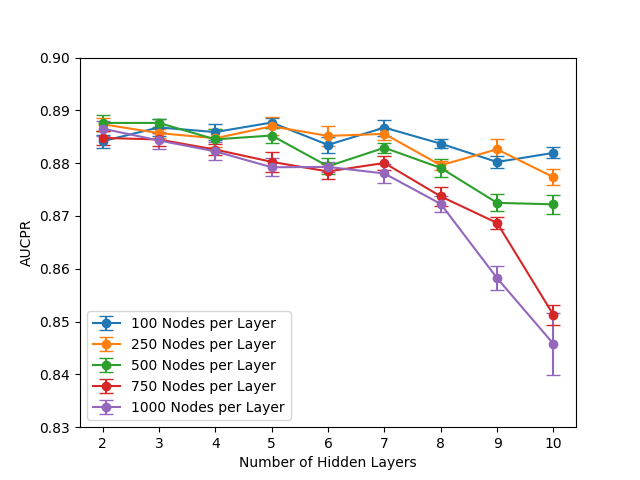

In [5]:
Image('Lab book Images/architecture_aucpr.png')

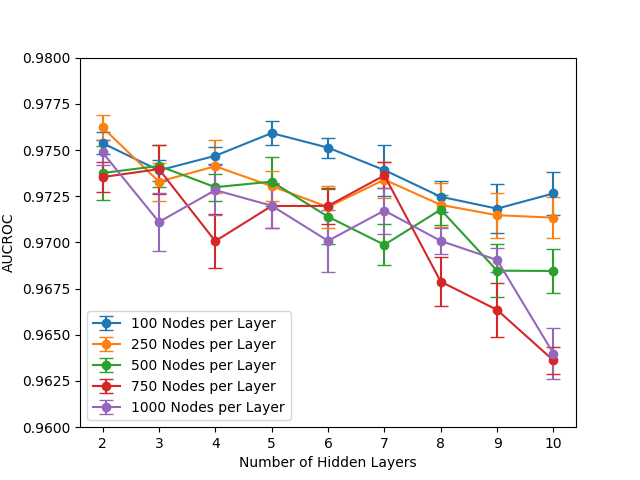

In [4]:
Image('Lab book Images/architecture_auroc.png')

## __Ensemble Training__

100 models of the chosen top architecture (100 nodes with 5 layers) were trained. Ideally I would've trained 1000, however this would have taken too long. In training run early stopping and model checkpoint were used to save the weights with the highest validation split AUCPR. A csv file of the training results for each training run was also saved.

In order to deal with VRAM memory limitations and prevent tensorflow from overloading the GPU memory this process was split into two scripts: __batch_train.py__ and __training.py__.

### __training.py__

Python script for:
- Training a single model
- Saving model with highest validation AUCPR using ModelCheckpoint
- Saving training metrics to a csv file

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python training.py
-h5 /path/to/training/data
-des /path/to/save/model&csv/
-layers "Hidden layer structure"
-num "Integer for numbering model file name"

### __batch_train.py__

Python script for:
- Running multiple instances of training.py for one architecture
- Using multithreading to run training.py multiple times at once

Terminal input parameters:

In [ ]:
# Unix code
# Input as one line
python batch_train.py
-train /path/to/training.py
-h5 /path/to/training/data
-des /path/to/output/directory/
-layers "Hidden layer structure"
-models "Number of models to train"

Inputs used:

In [ ]:
# Unix code
# Input as one line
python batch_train.py
-train /home/s1633589/modelBuilding/scripts/training.py
-h5 /home/s1633589/modelBuilding/data/training_data.h5
-des /home/s1633589/modelBuilding/models/
-layers 100,100,100,100,100
-models 100

## __Using Logistic Regression for Weighted Averaging__

The 100 models were ranked by their validation set AUCPR. Each model was used to make predictions on the validation set. Predictions were fitted to a logistic regression using varying numbers of the top models (1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100). Models were then used to predict on the test sets and the logistic regressions were used to combine model predictions. AUCPR and AUROC of predictions using different numbers of models are shown below

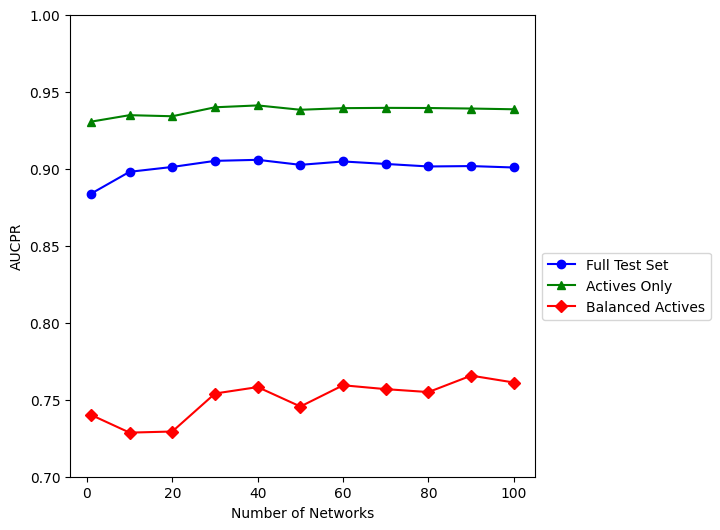

In [6]:
Image('Lab book Images/ensemble_pr.png')

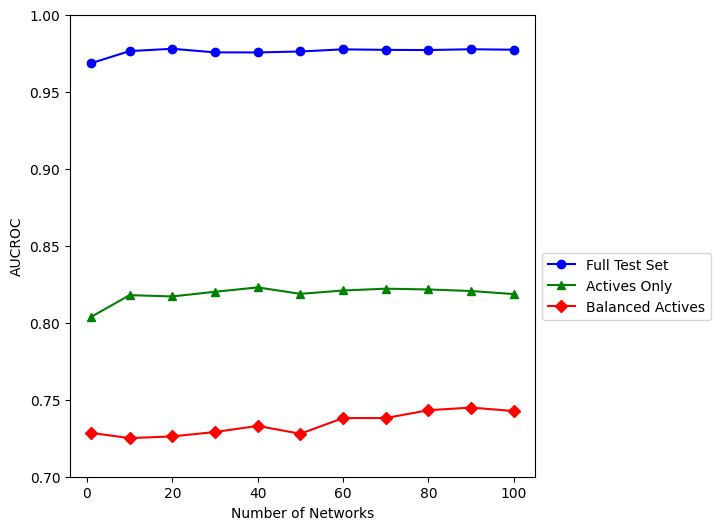

In [7]:
Image('Lab book Images/ensemble_roc.png')

## __Comparison with NNScore__

Test set predictions of the top 24 networks of NNScore were comparared to the top 90 ensemble networks developed here. The AUCPR and AUROC curves on the full test set are shown below

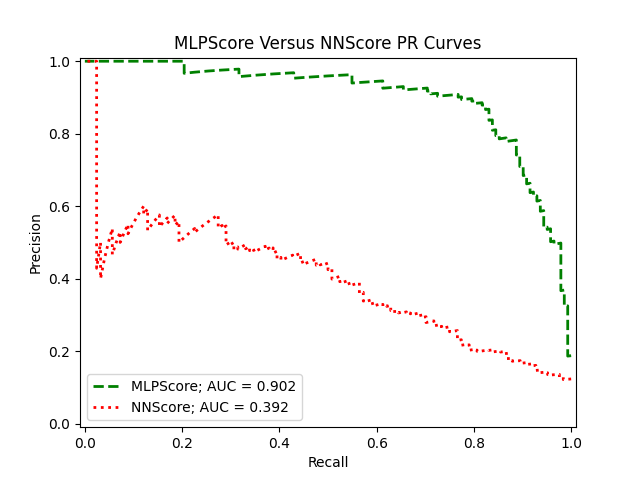

In [8]:
Image('Lab book Images/mlpscore_nnscore_pr.png')

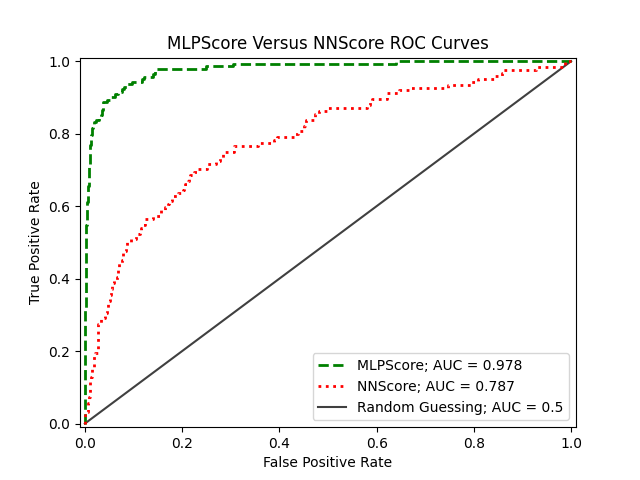

In [9]:
Image('Lab book Images/mlpscore_nnscore_roc.png')

A scatter of active test set predictions for both scoring functions is shown below

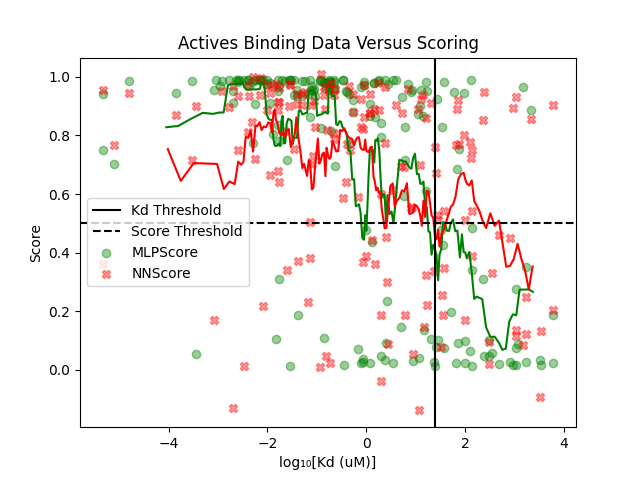

In [10]:
Image('Lab book Images/mlpscore_nnscore_scatter.png')

To determine if decoy bias was present in the dataset, performance on the different test sets was evaluated

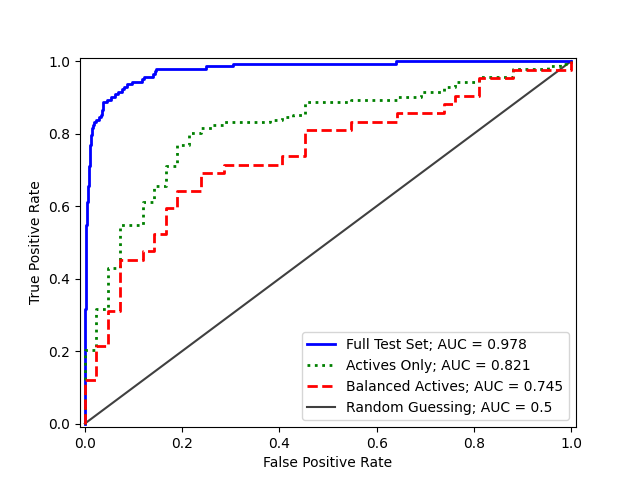

In [12]:
Image('Lab book Images/mlp_bias.png')

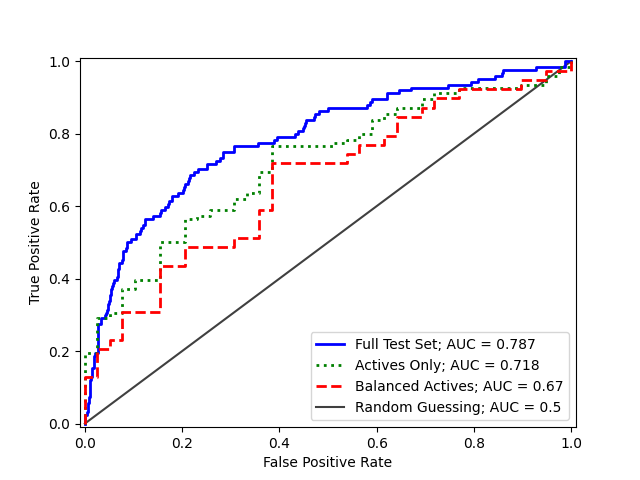

In [13]:
Image('Lab book Images/nn_bias.png')

---